# Project 2 - Multiple Myeloma Survival


In [1]:
import pandas as pd
import missingno as msno
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer # N RETIRAR
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, Pool

import os

# Set white background for all plots
plt.style.use('default')
sns.set_style("white")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Create plots directory
os.makedirs("./plots", exist_ok=True)

In [2]:
df = pd.read_csv('./data/train_data.csv')

In [3]:

def create_submission_file(predictions, filename):
    """
    Create a submission file with predictions.
    
    Args:
        predictions (array-like): The predicted values for SurvivalTime.
        filename (str): The name of the output file.
    """
    # Load the sample submission to get the 'Id' column structure
    sample_submission = pd.read_csv('./data/sample_submission.csv')

    # Ensure that predictions are a single column (reshape if necessary)
    predictions = pd.Series(predictions).values
    
    # Create the submission DataFrame
    submission = pd.DataFrame(columns=sample_submission.columns) 
    submission['id'] = range(len(predictions))
    submission['0'] = predictions # Add the predictions to the 'SurvivalTime' column

    # Save the DataFrame to CSV
    os.makedirs("./results", exist_ok=True)
    submission.to_csv(f'./results/{filename}', index=False)

    print(f"File Created: ./results/{filename}")


In [4]:
def error_metric(y, y_hat, c):
    """
    Censored Mean Squared Error calculation.
    c = 0 for uncensored data points
    c = 1 for censored data points
    
    Args:
        y (array-like): True Survival Time values.
        y_hat (array-like): Predicted Survival Time values.
        c (array-like): Censoring indicators (0 for uncensored, 1 for censored).
        
    Returns:
        float: The Censored Mean Squared Error.
    """
    err = y-y_hat
    err = (1-c)*err**2 + c*np.maximum(0,err)**2
    return np.sum(err)/err.shape[0]

## Task 1 - Setting the baseline

### Task 1.1 - Data preparation and validation pipeline

**1. Missing Values Analysis**

- Visualized missing values using multiple methods (bar plot, heatmap, matrix, dendrogram)
- Created comprehensive overview of data completeness
- Identified patterns in missing data

**2. Data Cleaning**

- Dropped rows with missing `SurvivalTime` values
- Removed columns containing missing data (baseline approach)
- Excluded censored cases (where `Censored == 1`)
- Retained only complete, uncensored observations

**3. Feature Exploration**

- Visualized feature relationships using pairplot
- Analyzed correlations between Age, Gender, Stage, TreatmentType, and SurvivalTime
- Examined distribution patterns across features

**4. Data Preparation**

- Defined feature matrix (X) by dropping target and identifier columns
- Isolated target variable (y) as SurvivalTime
- Preserved censoring indicator for potential future use

**5. Validation Strategy Development**

- Implemented train/validation/test split (64%/16%/20%)
- Tested simple split approach with Linear Regression
- Implemented 5-fold cross-validation for more robust evaluation
- Compared both validation strategies (simple split vs. cross-validation)

**6. Performance Evaluation**

- Calculated MSE (Mean Squared Error) and cMSE (Censored MSE)
- Evaluated model performance on validation and test sets
- Compared cross-validation results to simple split results


/Users/dinis/Universidade/AA/AA-Projeto2/.venv/lib/python3.12/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


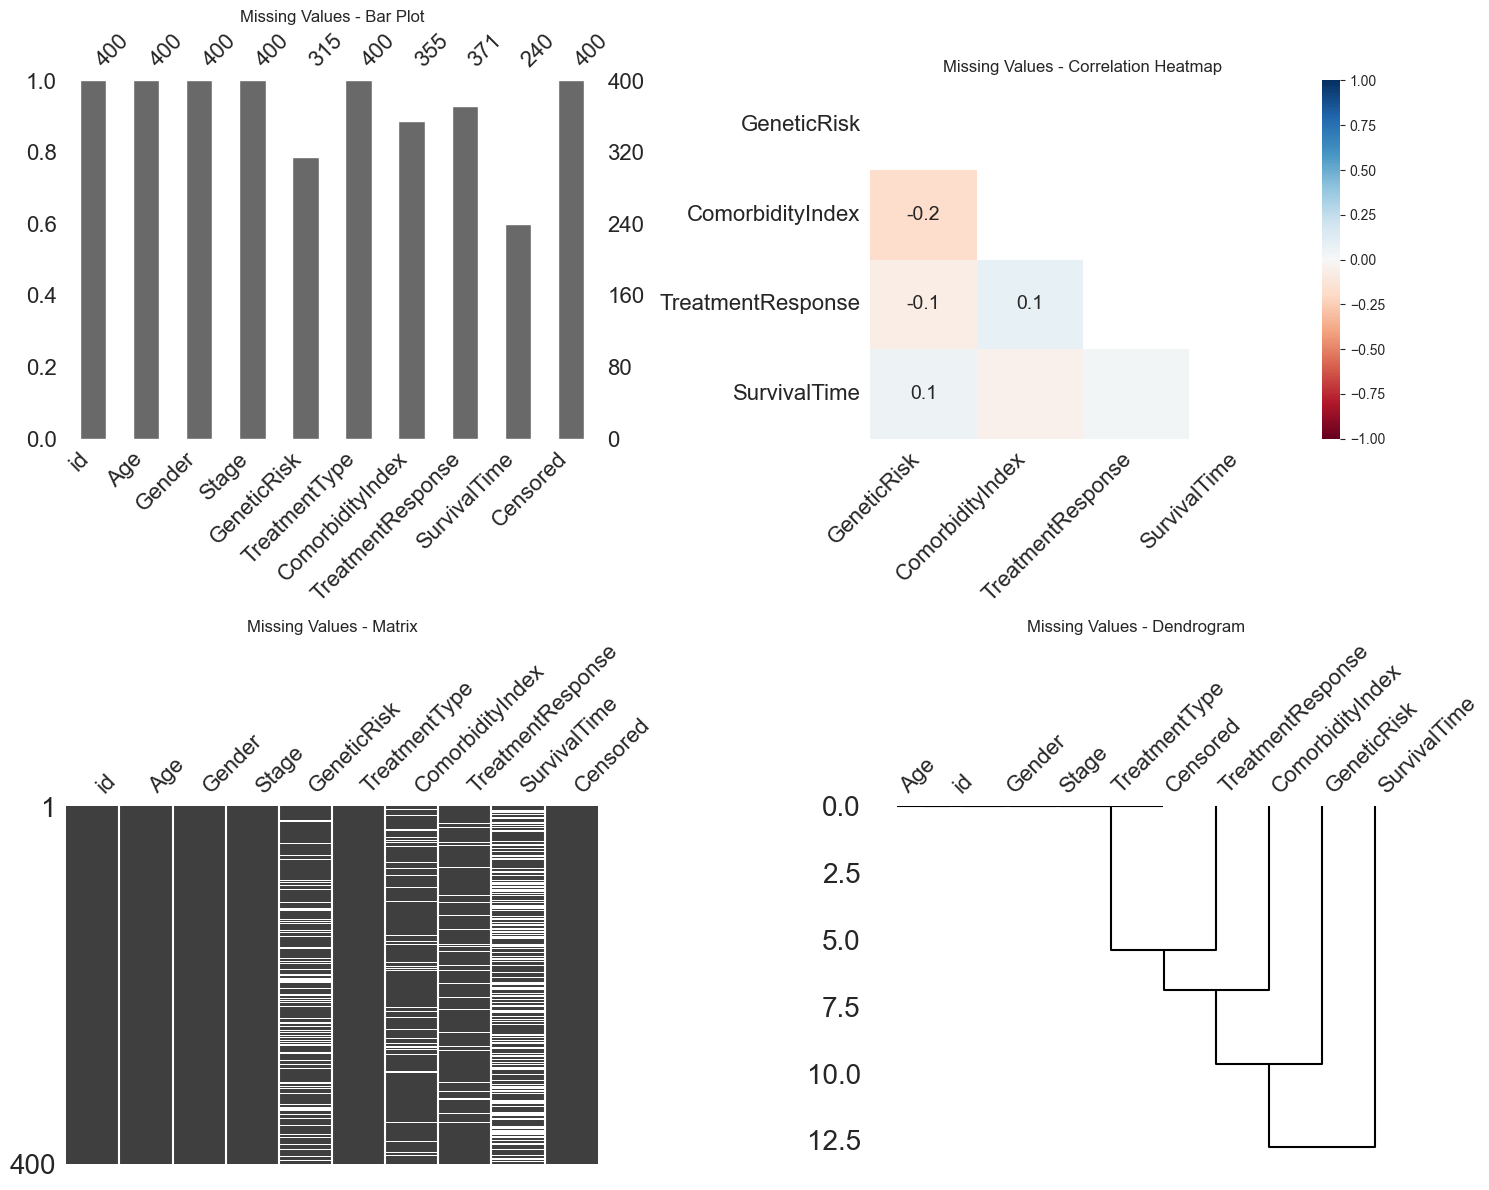

/Users/dinis/Universidade/AA/AA-Projeto2/.venv/lib/python3.12/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


In [5]:
# Visualize missing values using multiple missingno plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.patch.set_facecolor('white')

# Bar plot
plt.subplot(2, 2, 1)
msno.bar(df, ax=plt.gca())
plt.title('Missing Values - Bar Plot')

# Heatmap
plt.subplot(2, 2, 2)
msno.heatmap(df, ax=plt.gca())
plt.title('Missing Values - Correlation Heatmap')

# Matrix
plt.subplot(2, 2, 3)
msno.matrix(df, ax=plt.gca())
plt.title('Missing Values - Matrix')

# Dendrogram
plt.subplot(2, 2, 4)
msno.dendrogram(df, ax=plt.gca())
plt.title('Missing Values - Dendrogram')

plt.tight_layout()
plt.savefig('./plots/task1.1_missing_values_overview.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Save each plot separately
fig_bar = plt.figure(figsize=(10, 6))
fig_bar.patch.set_facecolor('white')
msno.bar(df, ax=plt.gca())
plt.title('Missing Values - Bar Plot')
plt.tight_layout()
plt.savefig('./plots/task1.1_missing_values_bar.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

fig_heatmap = plt.figure(figsize=(10, 6))
fig_heatmap.patch.set_facecolor('white')
msno.heatmap(df, ax=plt.gca())
plt.title('Missing Values - Correlation Heatmap')
plt.tight_layout()
plt.savefig('./plots/task1.1_missing_values_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

fig_matrix = plt.figure(figsize=(10, 6))
fig_matrix.patch.set_facecolor('white')
msno.matrix(df, ax=plt.gca())
plt.title('Missing Values - Matrix')
plt.tight_layout()
plt.savefig('./plots/task1.1_missing_values_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

fig_dendrogram = plt.figure(figsize=(10, 6))
fig_dendrogram.patch.set_facecolor('white')
msno.dendrogram(df, ax=plt.gca())
plt.title('Missing Values - Dendrogram')
plt.tight_layout()
plt.savefig('./plots/task1.1_missing_values_dendrogram.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

Original data points: 400
Remaining data points after cleaning: 161
Data points dropped: 239
Columns retained: ['id', 'Age', 'Gender', 'Stage', 'TreatmentType', 'SurvivalTime', 'Censored']


<Figure size 1000x600 with 0 Axes>

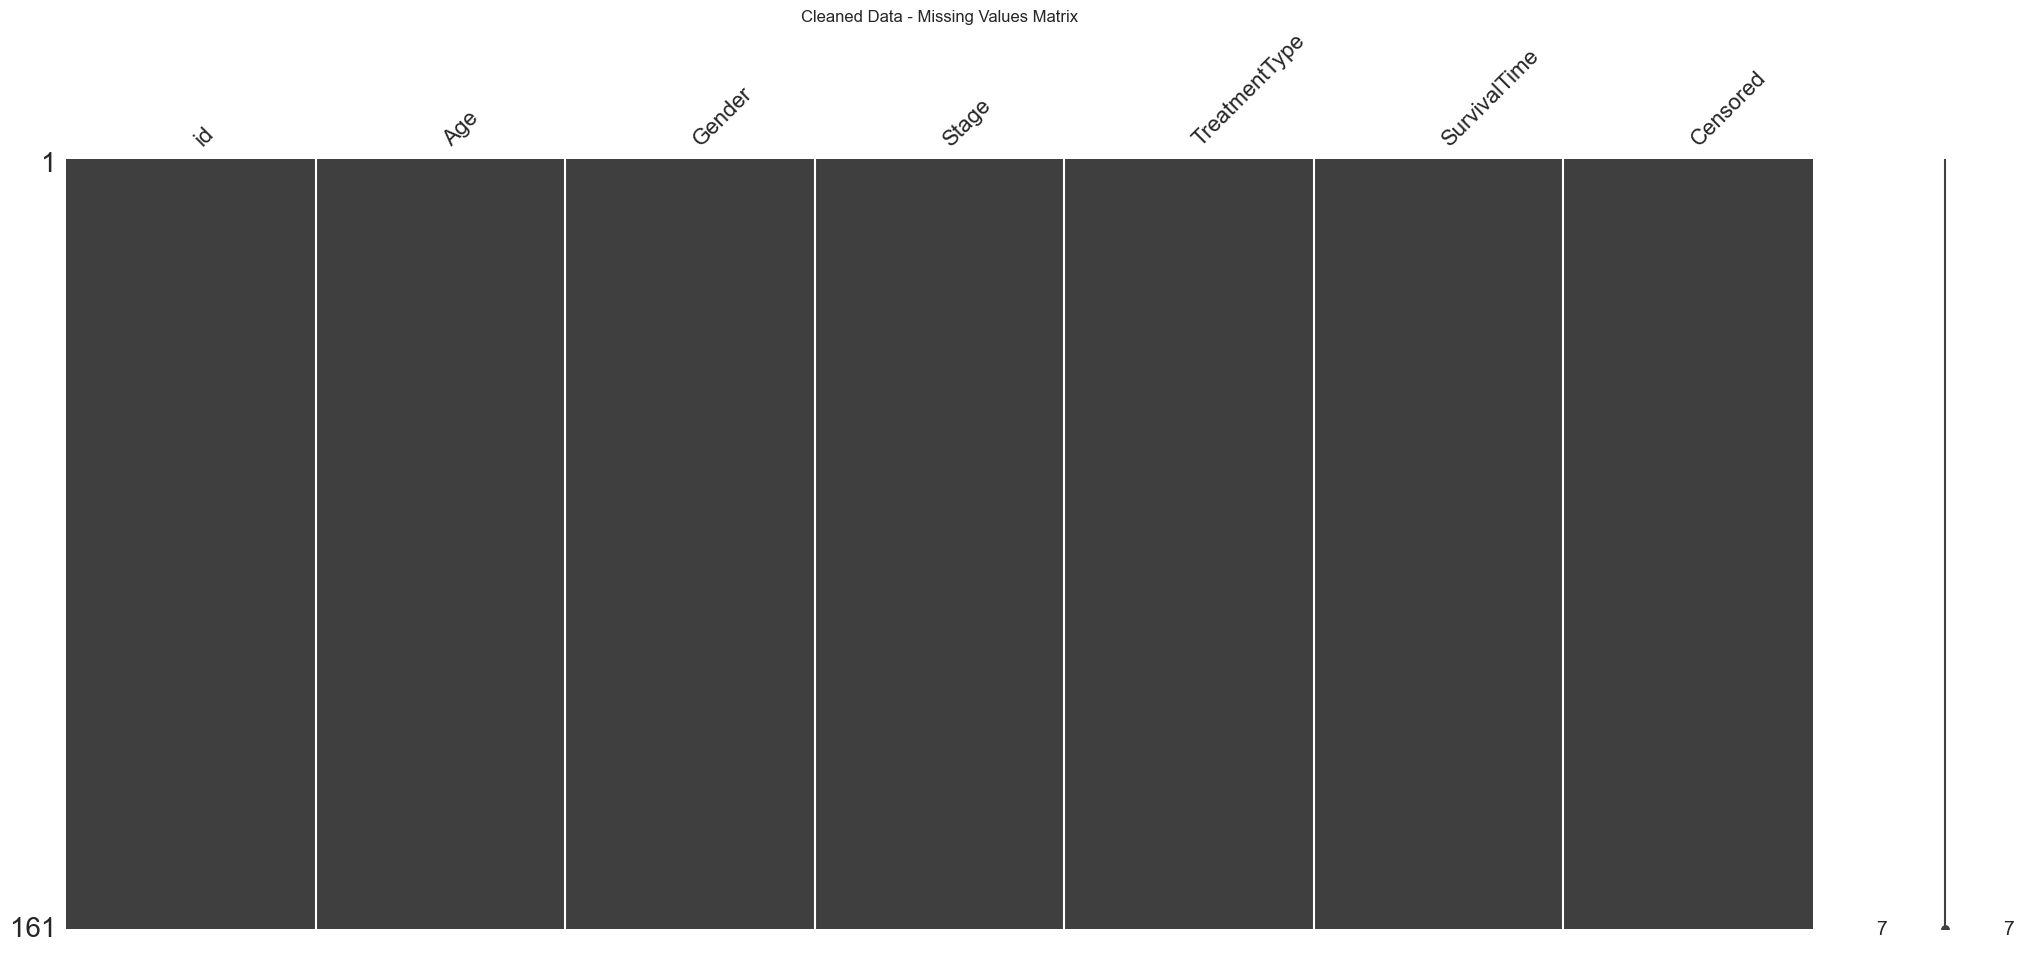

In [6]:
# Data cleaning for baseline model
# 1. Drop rows with missing 'SurvivalTime' values
df_cleaned = df[df['SurvivalTime'].notnull()].copy()

# 2. Drop columns with missing data (baseline approach)
df_cleaned = df_cleaned.dropna(axis=1)

# 3. Drop censored cases (Censored == 1) for baseline
# Censoring occurs when the exact time of an event (death/recurrence) is unknown
df_cleaned = df_cleaned[df_cleaned['Censored'] == 0]

print(f"Original data points: {df.shape[0]}")
print(f"Remaining data points after cleaning: {df_cleaned.shape[0]}")
print(f"Data points dropped: {df.shape[0] - df_cleaned.shape[0]}")
print(f"Columns retained: {list(df_cleaned.columns)}")

# Visualize cleaned data
fig = plt.figure(figsize=(10, 6))
fig.patch.set_facecolor('white')
msno.matrix(df_cleaned)
plt.title('Cleaned Data - Missing Values Matrix')
plt.savefig('./plots/task1.1_cleaned_data_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

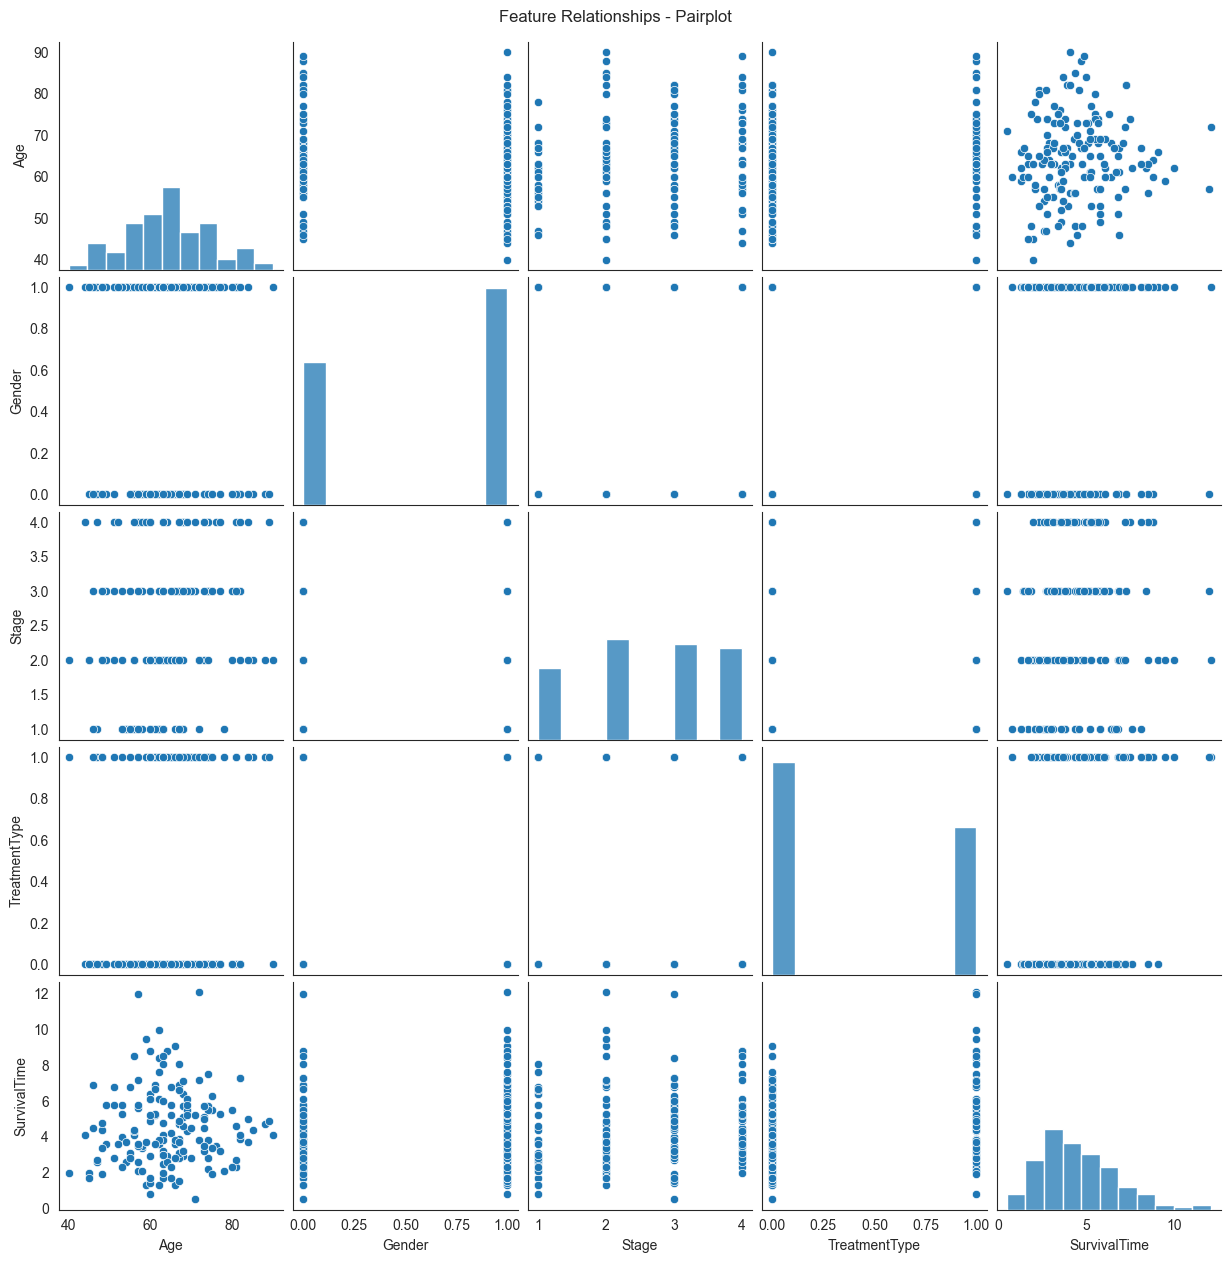

In [7]:
# Visualize feature relationships
# Note: Censored is excluded as it's a label indicator, not a predictive feature
feature_cols = ['Age', 'Gender', 'Stage', 'TreatmentType', 'SurvivalTime']
g = sns.pairplot(df_cleaned, vars=feature_cols)
g.fig.patch.set_facecolor('white')
plt.suptitle('Feature Relationships - Pairplot', y=1.01)
plt.savefig('./plots/task1.1_feature_pairplot.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [8]:
# Define the feature matrix (X) and target vector (y)
X = df_cleaned.drop(['SurvivalTime', 'Censored','id'], axis=1)  # Drop target and censoring indicator
y = df_cleaned['SurvivalTime']  # Target variable: survival time
censored = df_cleaned['Censored']  # Censoring indicator

In [9]:
# First split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: further divide train into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/X.shape[0]*100:.1f}%)")

Training set size: 102 (63.4%)
Validation set size: 26 (16.1%)
Test set size: 33 (20.5%)


In [10]:
# Simple train/validation/test approach (without cross-validation)
print("=" * 60)
print("Simple Train/Validation/Test Split Approach")
print("=" * 60)

# Train model
model_simple = LinearRegression()
model_simple.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = model_simple.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
print(f'Validation MSE: {val_mse:.4f}')

# Evaluate on test set
y_test_pred = model_simple.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test MSE: {test_mse:.4f}')

# Calculate cMSE (all data points are uncensored, so c=0)
test_cmse = error_metric(y_test, y_test_pred, 0)
print(f'Test cMSE: {test_cmse:.4f}')

Simple Train/Validation/Test Split Approach
Validation MSE: 3.3672
Test MSE: 5.0473
Test cMSE: 5.0473


In [11]:
# Cross-validation approach (more robust)
print("=" * 60)
print("Cross-Validation Approach (5-fold)")
print("=" * 60)

# Train with cross-validation
model_cv = LinearRegression()
cv_scores = cross_val_score(model_cv, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_scores  # Convert to positive MSE

print(f"Cross-validation MSE scores: {cv_mse_scores}")
print(f"Average CV MSE: {np.mean(cv_mse_scores):.4f} (+/- {np.std(cv_mse_scores):.4f})")

# Fit model on full dataset
model_cv.fit(X, y)
y_pred_cv = model_cv.predict(X)

# Calculate metrics
train_mse = mean_squared_error(y, y_pred_cv)
train_cmse = error_metric(y, y_pred_cv, censored)
print(f"Training MSE: {train_mse:.4f}")
print(f"Training cMSE: {train_cmse:.4f}")
print("=" * 60)

Cross-Validation Approach (5-fold)
Cross-validation MSE scores: [4.20703123 2.90729383 4.5532278  3.57321375 6.09991277]
Average CV MSE: 4.2681 (+/- 1.0747)
Training MSE: 4.0873
Training cMSE: 4.0873


Comparing the Avarage MSE Cross validation value and the MSE value simple, with Cross Validation is more efficient without Cross Validation because in cross-validation, the model is trained and validated multiple times using different splits of the dataset. This means that the model gets to train on almost all of the data, which helps the model generalize better.



Pipeline Approach (Scaling + Linear Regression)
Pipeline MSE: 4.4112
Pipeline cMSE: 4.4112

Comparison of All Approaches
Simple Split - Test MSE:  5.0473
Simple Split - Test cMSE: 5.0473
Cross-Val    - Train MSE: 4.0873
Cross-Val    - Train cMSE: 4.0873
Pipeline     - Test MSE:  4.4112
Pipeline     - Test cMSE: 4.4112


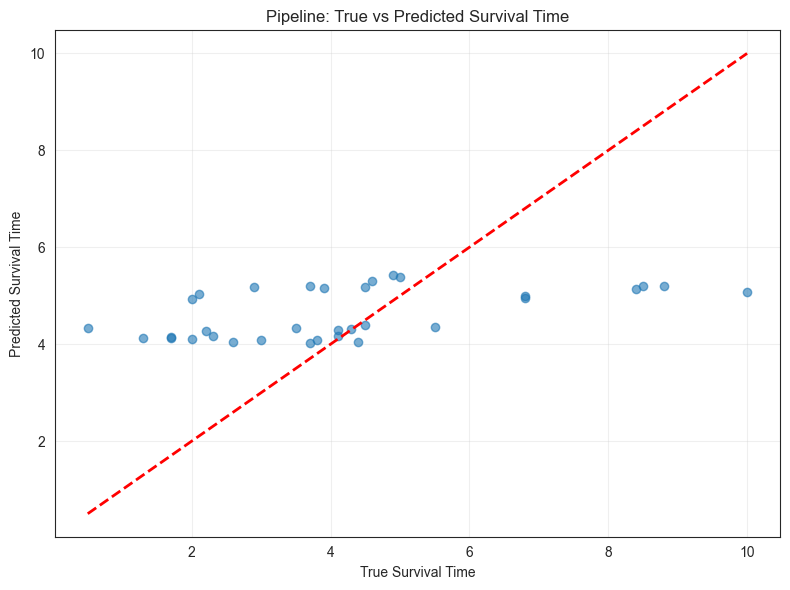

In [12]:
# Optional: Baseline model with pipeline (scaling + regression)
run_pipeline_test = bool(input("Run baseline model with pipeline? (y/n): ").lower() == "y")

if run_pipeline_test:
    print("\n" + "=" * 60)
    print("Pipeline Approach (Scaling + Linear Regression)")
    print("=" * 60)
    
    # Create fresh train/test split
    X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Build pipeline
    pipeline = make_pipeline(
        StandardScaler(),
        LinearRegression()
    )
    
    # Train and predict
    pipeline.fit(X_train_pipe, y_train_pipe)
    y_pred_pipe = pipeline.predict(X_test_pipe)
    
    # Evaluate
    mse_pipe = mean_squared_error(y_test_pipe, y_pred_pipe)
    cmse_pipe = error_metric(y_test_pipe, y_pred_pipe, 0)
    
    print(f"Pipeline MSE: {mse_pipe:.4f}")
    print(f"Pipeline cMSE: {cmse_pipe:.4f}")
    
    # Comparison with previous approaches
    print("\n" + "=" * 60)
    print("Comparison of All Approaches")
    print("=" * 60)
    print(f"Simple Split - Test MSE:  {test_mse:.4f}")
    print(f"Simple Split - Test cMSE: {test_cmse:.4f}")
    print(f"Cross-Val    - Train MSE: {train_mse:.4f}")
    print(f"Cross-Val    - Train cMSE: {train_cmse:.4f}")
    print(f"Pipeline     - Test MSE:  {mse_pipe:.4f}")
    print(f"Pipeline     - Test cMSE: {cmse_pipe:.4f}")
    print("=" * 60)
    
    show_plots = bool(input("Visualize pipeline results? (y/n): ").lower() == "y")

    if show_plots:
        fig = plt.figure(figsize=(8, 6))
        fig.patch.set_facecolor('white')
        plt.scatter(y_test_pipe, y_pred_pipe, alpha=0.6)
        plt.plot([y_test_pipe.min(), y_test_pipe.max()], 
                 [y_test_pipe.min(), y_test_pipe.max()], 'r--', lw=2)
        plt.xlabel('True Survival Time')
        plt.ylabel('Predicted Survival Time')
        plt.title('Pipeline: True vs Predicted Survival Time')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("Pipeline test skipped.")

    print("\n" + "=" * 60)
    print("Comparison of All Approaches")
    print("=" * 60)
    print(f"Simple Split - Test MSE:  {test_mse:.4f}")
    print(f"Simple Split - Test cMSE: {test_cmse:.4f}")
    print(f"Cross-Val    - Train MSE: {train_mse:.4f}")
    print(f"Cross-Val    - Train cMSE: {train_cmse:.4f}")
    print("=" * 60)

### Task 1.2 - Learn the baseline model

Train the final baseline model using cross-validation and generate predictions for submission.

**1. Pipeline Construction**

- Built baseline pipeline combining StandardScaler and Linear Regression
- Ensured feature scaling for improved model performance
- Created modular, reusable pipeline structure

**2. Cross-Validation Training**

- Performed 5-fold cross-validation for robust model evaluation
- Calculated CV MSE scores across all folds
- Computed mean and standard deviation of cross-validation performance

**3. Final Model Training**

- Fitted baseline pipeline on entire training dataset
- Generated predictions on training data
- Maximized use of available data for final model

**4. Performance Metrics**

- Calculated Training MSE (Mean Squared Error)
- Calculated Training cMSE (Censored Mean Squared Error)
- Established baseline performance benchmarks

**5. Test Predictions & Submission**

- Loaded test dataset and prepared features
- Generated predictions for test samples
- Created submission file for competition/evaluation

**6. Model Visualization**

- Created scatter plot comparing true vs predicted survival times
- Generated boxplot for distribution comparison
- Visualized model fit quality and prediction patterns
- Saved individual plots for documentation


In [13]:
# Build baseline pipeline with scaling and Linear Regression
baseline_pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

# Perform 5-fold cross-validation
print("=" * 60)
print("Baseline Model Training with Cross-Validation")
print("=" * 60)

cv_scores = cross_val_score(baseline_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_scores

print(f"CV MSE scores: {cv_mse_scores}")
print(f"Average CV MSE: {np.mean(cv_mse_scores):.4f} (+/- {np.std(cv_mse_scores):.4f})")

# Fit on entire training dataset
baseline_pipeline.fit(X, y)
y_pred_baseline = baseline_pipeline.predict(X)

# Evaluate final model
mse_baseline = mean_squared_error(y, y_pred_baseline)
cmse_baseline = error_metric(y, y_pred_baseline, censored)

print(f"\nFinal Model Performance:")
print(f"Training MSE:  {mse_baseline:.4f}")
print(f"Training cMSE: {cmse_baseline:.4f}")
print("=" * 60)

Baseline Model Training with Cross-Validation
CV MSE scores: [4.20703123 2.90729383 4.5532278  3.57321375 6.09991277]
Average CV MSE: 4.2681 (+/- 1.0747)

Final Model Performance:
Training MSE:  4.0873
Training cMSE: 4.0873


In [14]:
# Generate predictions for test dataset and create submission file
print("=" * 60)
print("Generating Submission File")
print("=" * 60)

# Load test data
df_test = pd.read_csv('./data/test_data.csv')

X_test_submission = df_test.drop(['id', 'GeneticRisk', 'TreatmentResponse', 'ComorbidityIndex'], axis=1)

y_test_predictions = baseline_pipeline.predict(X_test_submission)

create_submission_file(y_test_predictions, 'baseline-submission-01.csv')

print(f"Predictions generated for {len(y_test_predictions)} test samples")
print("=" * 60)

Generating Submission File
File Created: ./results/baseline-submission-01.csv
Predictions generated for 100 test samples


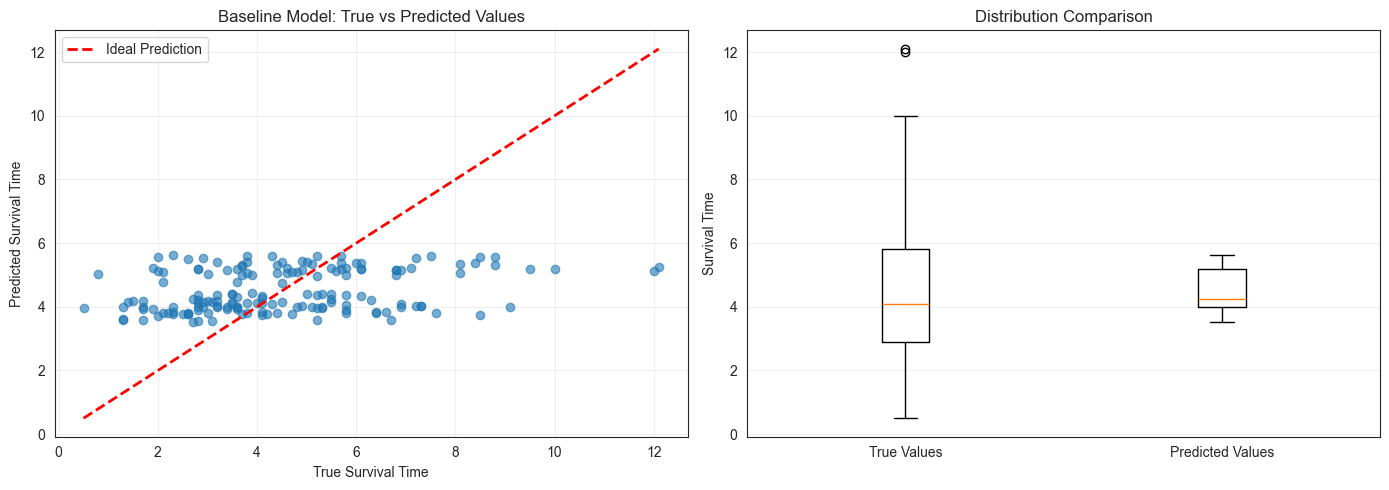

In [15]:
# Visualize model performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('white')

# Scatter plot: True vs Predicted
axes[0].scatter(y, y_pred_baseline, alpha=0.6)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal Prediction')
axes[0].set_xlabel('True Survival Time')
axes[0].set_ylabel('Predicted Survival Time')
axes[0].set_title('Baseline Model: True vs Predicted Values')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot: Distribution comparison
axes[1].boxplot([y, y_pred_baseline], tick_labels=["True Values", "Predicted Values"])
axes[1].set_ylabel('Survival Time')
axes[1].set_title('Distribution Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./plots/task1.2_baseline_model_performance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Save each plot separately
fig_scatter = plt.figure(figsize=(8, 6))
fig_scatter.patch.set_facecolor('white')
plt.scatter(y, y_pred_baseline, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal Prediction')
plt.xlabel('True Survival Time')
plt.ylabel('Predicted Survival Time')
plt.title('Baseline Model: True vs Predicted Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./plots/task1.2_baseline_scatter_plot.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

fig_boxplot = plt.figure(figsize=(8, 6))
fig_boxplot.patch.set_facecolor('white')
plt.boxplot([y, y_pred_baseline], tick_labels=["True Values", "Predicted Values"])
plt.ylabel('Survival Time')
plt.title('Distribution Comparison')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('./plots/task1.2_baseline_boxplot.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

## Task 2 - Nonlinear models

### Task 2.1 - Development

Develop functions for training Polynomial Regression and k-Nearest Neighbors on the data prepared in Task 1.1, using the validation procedure determined in Task 1.1 and Task 1.2.

Select model hyperparameters (polynomial degree and k) using cross-validation for model selection.

**1. Polynomial Regression Function Development**

- Created `train_polynomial_regression()` function with hyperparameter search
- Implemented cross-validation for degree selection (testing degrees 1 to max_degree)
- Added early stopping mechanism (stops after 2 consecutive iterations without improvement)
- Returned best degree, trained model, and complete CV results dictionary

**2. k-Nearest Neighbors Function Development**

- Created `train_knn()` function with hyperparameter search
- Implemented cross-validation for k selection (testing k from 1 to max_k)
- Added early stopping mechanism for efficiency
- Returned best k value, trained model, and complete CV results dictionary

**3. Hyperparameter Selection**

- Used 5-fold cross-validation for both models
- Searched polynomial degrees from 1 to 10
- Searched k values from 1 to 20
- Tracked MSE scores with standard deviations for each hyperparameter

**4. Model Training**

- Trained Polynomial Regression with optimal degree on full dataset
- Trained k-NN Regression with optimal k on full dataset
- Generated predictions on training data for both models

**5. Performance Evaluation**

- Calculated training MSE for both models
- Calculated training cMSE for both models
- Compared performance against baseline expectations
- Documented hyperparameter selection results


In [16]:
def train_polynomial_regression(X, y, max_degree=15, cv=5):
    """
    Trains and evaluates Polynomial Regression with cross-validation for hyperparameter selection.
    
    Args:
        X: Feature matrix
        y: Target variable
        max_degree: Maximum polynomial degree to test
        cv: Number of cross-validation folds
    
    Returns:
        best_degree: Optimal polynomial degree
        best_model: Trained model with best degree
        cv_results: Dictionary with all CV scores for each degree
    """
    cv_results = {
        'degrees': [],
        'mean_scores': [],
        'std_scores': [],
        'all_scores': []
    }
    
    best_score = -np.inf
    best_degree = None
    counter = 0
    
    print("=" * 60)
    print("Polynomial Regression - Hyperparameter Selection")
    print("=" * 60)
    
    # Search over polynomial degrees
    for degree in range(1, max_degree + 1):
        model = make_pipeline(
            StandardScaler(),
            PolynomialFeatures(degree),
            LinearRegression()
        )
        
        # Cross-validation
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        
        # Store results
        cv_results['degrees'].append(degree)
        cv_results['mean_scores'].append(-mean_score)
        cv_results['std_scores'].append(std_score)
        cv_results['all_scores'].append(-scores)
        
        print(f"Degree {degree}: MSE = {-mean_score:.4f} (+/- {std_score:.4f})")
        
        # Track best model
        if mean_score > best_score:
            best_score = mean_score
            best_degree = degree
            counter = 0
        else:
            counter += 1
            if counter >= 2:
                print("No improvement in 2 consecutive degrees, stopping early.")
                break

    
    print("=" * 60)
    print(f"Best Polynomial Degree: {best_degree}")
    print(f"Best Cross-Validation MSE: {-best_score:.4f}")
    print("=" * 60)
    
    # Train final model with best degree
    best_model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(best_degree),
        LinearRegression()
    )
    best_model.fit(X, y)
    
    return best_degree, best_model, cv_results

In [17]:
def train_knn(X, y, max_k=20, cv=5):
    """
    Trains and evaluates k-Nearest Neighbors with cross-validation for hyperparameter selection.
    
    Args:
        X: Feature matrix
        y: Target variable
        max_k: Maximum number of neighbors to test
        cv: Number of cross-validation folds
    
    Returns:
        best_k: Optimal number of neighbors
        best_model: Trained model with best k
        cv_results: Dictionary with all CV scores for each k
    """
    cv_results = {
        'k_values': [],
        'mean_scores': [],
        'std_scores': [],
        'all_scores': []
    }
    
    best_score = -np.inf
    best_k = None
    counter = 0
    
    print("=" * 60)
    print("k-Nearest Neighbors - Hyperparameter Selection")
    print("=" * 60)
    
    # Search over k values
    for k in range(1, max_k + 1):
        model = make_pipeline(
            StandardScaler(),
            KNeighborsRegressor(n_neighbors=k)
        )
        
        # Cross-validation
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        
        # Store results
        cv_results['k_values'].append(k)
        cv_results['mean_scores'].append(-mean_score)
        cv_results['std_scores'].append(std_score)
        cv_results['all_scores'].append(-scores)
        
        print(f"k = {k:2d}: MSE = {-mean_score:.4f} (+/- {std_score:.4f})")
        
        # Track best model
        if mean_score > best_score:
            best_score = mean_score
            best_k = k
            counter = 0
        else:
            counter += 1
            if counter >= 2:
                print("No improvement in 2 consecutive k values, stopping early.")
                break
    
    print("=" * 60)
    print(f"Best k (Neighbors): {best_k}")
    print(f"Best Cross-Validation MSE: {-best_score:.4f}")
    print("=" * 60)
    
    # Train final model with best k
    best_model = make_pipeline(
        StandardScaler(),
        KNeighborsRegressor(n_neighbors=best_k)
    )
    best_model.fit(X, y)
    
    return best_k, best_model, cv_results

In [18]:
# Train Polynomial Regression with hyperparameter selection
print("\nTraining Polynomial Regression...")
best_poly_degree, poly_model, poly_cv_results = train_polynomial_regression(X, y, max_degree=10, cv=5)

# Train k-NN Regressor with hyperparameter selection
print("\nTraining k-Nearest Neighbors...")
best_k, knn_model, knn_cv_results = train_knn(X, y, max_k=20, cv=5)

# Generate predictions on training data
y_pred_poly = poly_model.predict(X)
y_pred_knn = knn_model.predict(X)

# Calculate training metrics
mse_poly_train = mean_squared_error(y, y_pred_poly)
mse_knn_train = mean_squared_error(y, y_pred_knn)
cmse_poly_train = error_metric(y, y_pred_poly, censored)
cmse_knn_train = error_metric(y, y_pred_knn, censored)

print("\n" + "=" * 60)
print("Training Performance Summary")
print("=" * 60)
print(f"Polynomial Regression (degree={best_poly_degree}):")
print(f"  Training MSE:  {mse_poly_train:.4f}")
print(f"  Training cMSE: {cmse_poly_train:.4f}")
print(f"\nk-NN Regression (k={best_k}):")
print(f"  Training MSE:  {mse_knn_train:.4f}")
print(f"  Training cMSE: {cmse_knn_train:.4f}")
print("=" * 60)


Training Polynomial Regression...
Polynomial Regression - Hyperparameter Selection
Degree 1: MSE = 4.2681 (+/- 1.0747)
Degree 2: MSE = 4.4826 (+/- 0.9745)
Degree 3: MSE = 5.0524 (+/- 1.9355)
No improvement in 2 consecutive degrees, stopping early.
Best Polynomial Degree: 1
Best Cross-Validation MSE: 4.2681

Training k-Nearest Neighbors...
k-Nearest Neighbors - Hyperparameter Selection
k =  1: MSE = 6.5911 (+/- 2.4244)
k =  2: MSE = 5.5004 (+/- 1.5451)
k =  3: MSE = 5.0343 (+/- 1.3577)
k =  4: MSE = 5.1309 (+/- 1.1098)
k =  5: MSE = 4.8345 (+/- 1.0953)
k =  6: MSE = 4.6481 (+/- 1.0142)
k =  7: MSE = 4.5541 (+/- 0.8822)
k =  8: MSE = 4.4388 (+/- 0.9048)
k =  9: MSE = 4.2866 (+/- 0.8962)
k = 10: MSE = 4.1907 (+/- 0.8092)
k = 11: MSE = 4.2780 (+/- 0.7716)
k = 12: MSE = 4.2449 (+/- 0.9327)
No improvement in 2 consecutive k values, stopping early.
Best k (Neighbors): 10
Best Cross-Validation MSE: 4.1907

Training Performance Summary
Polynomial Regression (degree=1):
  Training MSE:  4.0873


### Task 2.2 - Evaluation

Evaluate the models developed in Task 2.1 against the baseline. Analysis backed with evidence through tables displaying different models and their metrics (max, min, mean error, and standard deviation).

**1. Comprehensive Model Comparison**

- Created comparison table with baseline, polynomial regression, and k-NN models
- Included hyperparameter configurations for each model
- Displayed min, max, mean, and standard deviation of errors
- Identified best performing model based on mean cross-validation error

**2. Hyperparameter Tuning Visualization**

- Plotted polynomial degree vs MSE with confidence intervals
- Plotted k-value vs MSE with confidence intervals
- Marked optimal hyperparameters with vertical lines
- Showed performance trends across hyperparameter ranges

**3. Model Predictions Comparison**

- Created scatter plots of true vs predicted values for all three models
- Displayed MSE on each plot for direct comparison
- Included ideal prediction line (y=x) as reference
- Generated combined and individual visualization plots

**4. Statistical Analysis**

- Computed cross-validation statistics for each model
- Analyzed variance in predictions across folds
- Compared model stability through standard deviation metrics
- Evaluated improvement over baseline model

**5. Test Set Predictions**

- Selected best performing model based on CV results
- Generated predictions for test dataset
- Created submission file for evaluation
- Documented model selection rationale

**6. Results Documentation**

- Saved all comparison plots with task-specific naming
- Generated separate plots for polynomial and k-NN tuning
- Created individual prediction visualizations for each model
- Documented complete evaluation workflow


In [19]:
# Comprehensive model comparison table
print("\n" + "=" * 88)
print("MODEL EVALUATION - COMPARISON TABLE")
print("=" * 88)

# Collect all model results
models_data = []

# Baseline model (from Task 1.2)
baseline_cv_scores = cross_val_score(baseline_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
baseline_errors = -baseline_cv_scores
models_data.append({
    'Model': 'Baseline (Linear Regression)',
    'Hyperparameter': 'N/A',
    'Min Error': np.min(baseline_errors),
    'Max Error': np.max(baseline_errors),
    'Mean Error': np.mean(baseline_errors),
    'Std Error': np.std(baseline_errors)
})

# Polynomial Regression
poly_errors = np.array(poly_cv_results['mean_scores'])
best_poly_idx = poly_cv_results['degrees'].index(best_poly_degree)
best_poly_scores = poly_cv_results['all_scores'][best_poly_idx]
models_data.append({
    'Model': 'Polynomial Regression',
    'Hyperparameter': f'degree={best_poly_degree}',
    'Min Error': np.min(best_poly_scores),
    'Max Error': np.max(best_poly_scores),
    'Mean Error': np.mean(best_poly_scores),
    'Std Error': np.std(best_poly_scores)
})

# k-NN Regression
knn_errors = np.array(knn_cv_results['mean_scores'])
best_knn_idx = knn_cv_results['k_values'].index(best_k)
best_knn_scores = knn_cv_results['all_scores'][best_knn_idx]
models_data.append({
    'Model': 'k-NN Regression',
    'Hyperparameter': f'k={best_k}',
    'Min Error': np.min(best_knn_scores),
    'Max Error': np.max(best_knn_scores),
    'Mean Error': np.mean(best_knn_scores),
    'Std Error': np.std(best_knn_scores)
})

# Create comparison DataFrame
comparison_df = pd.DataFrame(models_data)
comparison_df = comparison_df.round(4)

print(comparison_df.to_string(index=False))
print("=" * 88)

# Identify best model
best_model_idx = comparison_df['Mean Error'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"Best Model: {best_model_name}")
print(f"Mean CV Error: {comparison_df.loc[best_model_idx, 'Mean Error']:.4f}")
print("=" * 88)


MODEL EVALUATION - COMPARISON TABLE
                       Model Hyperparameter  Min Error  Max Error  Mean Error  Std Error
Baseline (Linear Regression)            N/A     2.9073     6.0999      4.2681     1.0747
       Polynomial Regression       degree=1     2.9073     6.0999      4.2681     1.0747
             k-NN Regression           k=10     3.0914     5.5670      4.1907     0.8092
Best Model: k-NN Regression
Mean CV Error: 4.1907


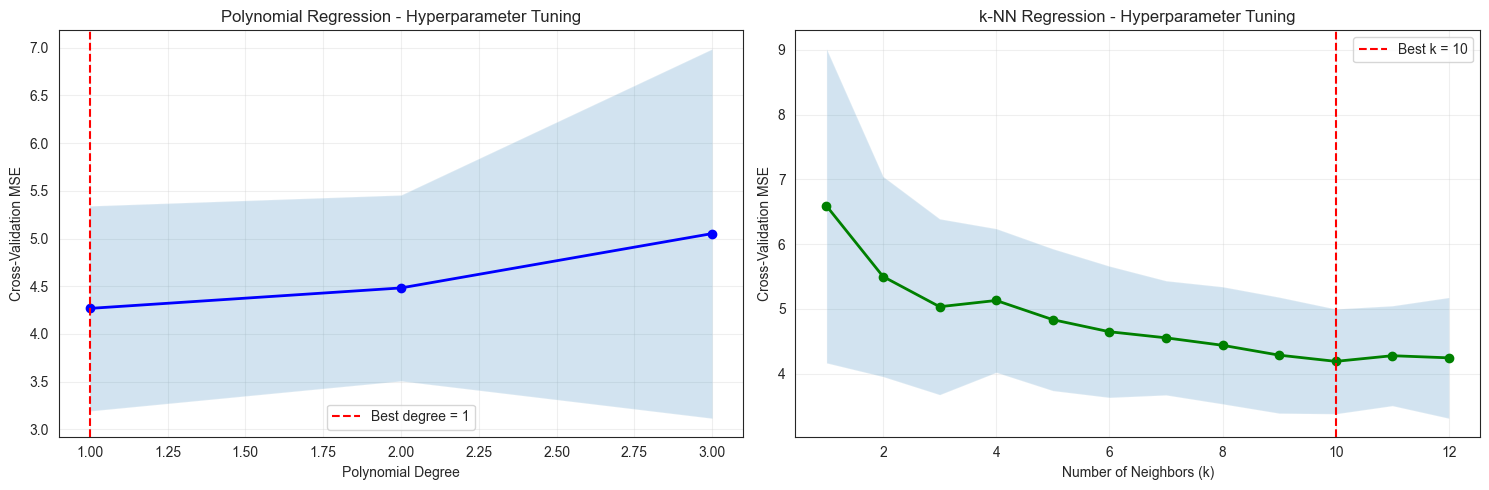

In [20]:
# Visualize hyperparameter tuning results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.patch.set_facecolor('white')

# Polynomial Regression: Degree vs MSE
axes[0].plot(poly_cv_results['degrees'], poly_cv_results['mean_scores'], 'b-o', linewidth=2, markersize=6)
axes[0].fill_between(
    poly_cv_results['degrees'],
    np.array(poly_cv_results['mean_scores']) - np.array(poly_cv_results['std_scores']),
    np.array(poly_cv_results['mean_scores']) + np.array(poly_cv_results['std_scores']),
    alpha=0.2
)
axes[0].axvline(x=best_poly_degree, color='r', linestyle='--', label=f'Best degree = {best_poly_degree}')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('Cross-Validation MSE')
axes[0].set_title('Polynomial Regression - Hyperparameter Tuning')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# k-NN: k vs MSE
axes[1].plot(knn_cv_results['k_values'], knn_cv_results['mean_scores'], 'g-o', linewidth=2, markersize=6)
axes[1].fill_between(
    knn_cv_results['k_values'],
    np.array(knn_cv_results['mean_scores']) - np.array(knn_cv_results['std_scores']),
    np.array(knn_cv_results['mean_scores']) + np.array(knn_cv_results['std_scores']),
    alpha=0.2
)
axes[1].axvline(x=best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
axes[1].set_xlabel('Number of Neighbors (k)')
axes[1].set_ylabel('Cross-Validation MSE')
axes[1].set_title('k-NN Regression - Hyperparameter Tuning')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/task2.2_hyperparameter_tuning.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Save individual plots separately
# Polynomial Regression plot
fig_poly = plt.figure(figsize=(8, 6))
fig_poly.patch.set_facecolor('white')
plt.plot(poly_cv_results['degrees'], poly_cv_results['mean_scores'], 'b-o', linewidth=2, markersize=6)
plt.fill_between(
    poly_cv_results['degrees'],
    np.array(poly_cv_results['mean_scores']) - np.array(poly_cv_results['std_scores']),
    np.array(poly_cv_results['mean_scores']) + np.array(poly_cv_results['std_scores']),
    alpha=0.2
)
plt.axvline(x=best_poly_degree, color='r', linestyle='--', label=f'Best degree = {best_poly_degree}')
plt.xlabel('Polynomial Degree')
plt.ylabel('Cross-Validation MSE')
plt.title('Polynomial Regression - Hyperparameter Tuning')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./plots/task2.2_polynomial_tuning.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

# k-NN plot
fig_knn = plt.figure(figsize=(8, 6))
fig_knn.patch.set_facecolor('white')
plt.plot(knn_cv_results['k_values'], knn_cv_results['mean_scores'], 'g-o', linewidth=2, markersize=6)
plt.fill_between(
    knn_cv_results['k_values'],
    np.array(knn_cv_results['mean_scores']) - np.array(knn_cv_results['std_scores']),
    np.array(knn_cv_results['mean_scores']) + np.array(knn_cv_results['std_scores']),
    alpha=0.2
)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation MSE')
plt.title('k-NN Regression - Hyperparameter Tuning')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./plots/task2.2_knn_tuning.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

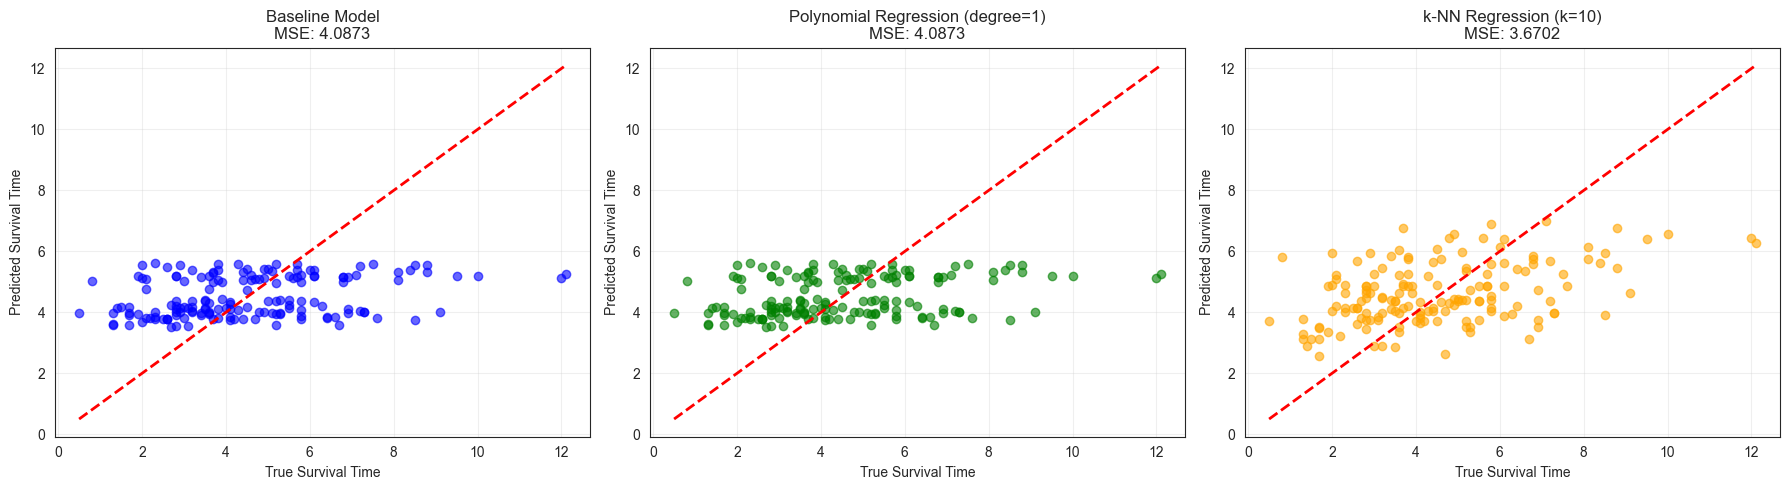

In [21]:
# Visualize predictions for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.patch.set_facecolor('white')

# Baseline predictions
axes[0].scatter(y, y_pred_baseline, alpha=0.6, color='blue')
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0].set_xlabel('True Survival Time')
axes[0].set_ylabel('Predicted Survival Time')
axes[0].set_title(f'Baseline Model\nMSE: {mse_baseline:.4f}')
axes[0].grid(True, alpha=0.3)

# Polynomial predictions
axes[1].scatter(y, y_pred_poly, alpha=0.6, color='green')
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[1].set_xlabel('True Survival Time')
axes[1].set_ylabel('Predicted Survival Time')
axes[1].set_title(f'Polynomial Regression (degree={best_poly_degree})\nMSE: {mse_poly_train:.4f}')
axes[1].grid(True, alpha=0.3)

# k-NN predictions
axes[2].scatter(y, y_pred_knn, alpha=0.6, color='orange')
axes[2].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[2].set_xlabel('True Survival Time')
axes[2].set_ylabel('Predicted Survival Time')
axes[2].set_title(f'k-NN Regression (k={best_k})\nMSE: {mse_knn_train:.4f}')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/task2.2_model_predictions_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Save individual prediction plots separately
# Polynomial Regression predictions
fig_poly_pred = plt.figure(figsize=(8, 6))
fig_poly_pred.patch.set_facecolor('white')
plt.scatter(y, y_pred_poly, alpha=0.6, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('True Survival Time')
plt.ylabel('Predicted Survival Time')
plt.title(f'Polynomial Regression (degree={best_poly_degree})\nMSE: {mse_poly_train:.4f}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./plots/task2.2_polynomial_predictions.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

# k-NN predictions
fig_knn_pred = plt.figure(figsize=(8, 6))
fig_knn_pred.patch.set_facecolor('white')
plt.scatter(y, y_pred_knn, alpha=0.6, color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('True Survival Time')
plt.ylabel('Predicted Survival Time')
plt.title(f'k-NN Regression (k={best_k})\nMSE: {mse_knn_train:.4f}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./plots/task2.2_knn_predictions.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

In [22]:
# Generate predictions for test dataset and create submission file
print("\n" + "=" * 60)
print("Generating Submission File for Task 2")
print("=" * 60)

# Load test data
df_test_task2 = pd.read_csv('./data/test_data.csv')
X_test_task2 = df_test_task2.drop(['id', 'GeneticRisk', 'TreatmentResponse', 'ComorbidityIndex'], axis=1)

# Determine which model to submit based on best CV performance
if comparison_df.loc[best_model_idx, 'Model'] == 'Polynomial Regression':
    best_predictions = poly_model.predict(X_test_task2)
    model_info = f"Polynomial Regression (degree={best_poly_degree})"
elif comparison_df.loc[best_model_idx, 'Model'] == 'k-NN Regression':
    best_predictions = knn_model.predict(X_test_task2)
    model_info = f"k-NN Regression (k={best_k})"
else:
    # If baseline is still best, use polynomial as nonlinear alternative
    best_predictions = poly_model.predict(X_test_task2)
    model_info = f"Polynomial Regression (degree={best_poly_degree})"

print(f"Best model selected: {model_info}")

# Create submission file
create_submission_file(best_predictions, 'Nonlinear-submission-01.csv')

print(f"Predictions generated for {len(best_predictions)} test samples")
print("=" * 60)


Generating Submission File for Task 2
Best model selected: k-NN Regression (k=10)
File Created: ./results/Nonlinear-submission-01.csv
Predictions generated for 100 test samples


## Task 3 - Handling missing data

### Task 3.1 - Missing data imputation

**1. Data Preparation**

- Load original dataset with missing values
- Analyze missing value patterns
- Prepare feature matrix (X) and target variable (y) with missing data intact

**2. Imputation Strategies**

- **Mean Imputation**: Replace missing values with column means
- **KNN Imputation**: Use k-nearest neighbors to estimate missing values
- **Iterative Imputation**: Use Bayesian Ridge regression for multivariate imputation

**3. Model Evaluation**

- Train baseline Linear Regression model on each imputed dataset
- Evaluate using both train/test split and cross-validation approaches
- Compare performance using cMSE (Censored Mean Squared Error)
- Test with KNN Regression model for comparison


In [23]:
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)
print()

X_missingValues = df.drop(['SurvivalTime', 'Censored', 'id'], axis=1)
y_missingValues = df['SurvivalTime']
censored_missingValues = df['Censored']

print(f"Total data points: {df.shape[0]}")
print(f"Features shape: {X_missingValues.shape}")
print(f"Target shape: {y_missingValues.shape}")

Missing values per column:
id                     0
Age                    0
Gender                 0
Stage                  0
GeneticRisk           85
TreatmentType          0
ComorbidityIndex      45
TreatmentResponse     29
SurvivalTime         160
Censored               0
dtype: int64

Total data points: 400
Features shape: (400, 7)
Target shape: (400,)


#### Strategy 1: Mean Imputation


In [24]:
mean_imputer = SimpleImputer(strategy='mean')

X_imputed_mean = mean_imputer.fit_transform(X_missingValues)
print(f"Features imputed: {X_imputed_mean.shape}")

y_imputed_mean = mean_imputer.fit_transform(y_missingValues.values.reshape(-1, 1))
print(f"Target imputed: {y_imputed_mean.shape}")

Features imputed: (400, 7)
Target imputed: (400, 1)


#### Strategy 2: KNN Imputation


In [25]:
knn_imputer = KNNImputer(n_neighbors=5)

X_imputed_knn = knn_imputer.fit_transform(X_missingValues)
print(f"Features imputed: {X_imputed_knn.shape}")

y_imputed_knn = knn_imputer.fit_transform(y_missingValues.values.reshape(-1, 1))
print(f"Target imputed: {y_imputed_knn.shape}")

Features imputed: (400, 7)
Target imputed: (400, 1)


#### Strategy 3: Iterative Imputation (Bayesian Ridge)


In [26]:
iterative_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42)

X_imputed_iterative = iterative_imputer.fit_transform(X_missingValues)
print(f"Features imputed: {X_imputed_iterative.shape}")

y_imputed_iterative = iterative_imputer.fit_transform(y_missingValues.values.reshape(-1, 1))
print(f"Target imputed: {y_imputed_iterative.shape}")

Features imputed: (400, 7)
Target imputed: (400, 1)


#### Evaluation 1: Baseline Linear Regression with Train/Test Split



Mean Imputation:
  MSE:  1.8127
  cMSE: 1.4788


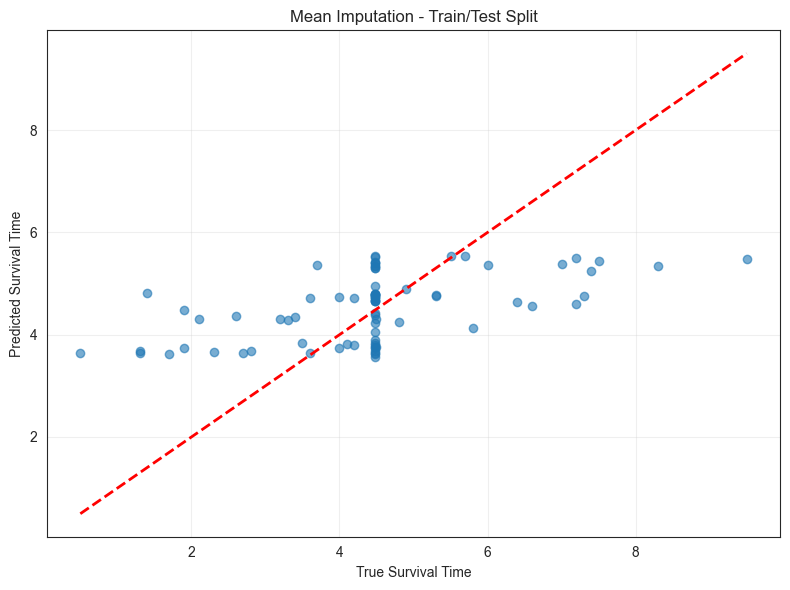


KNN Imputation:
  MSE:  1.8221
  cMSE: 1.4891


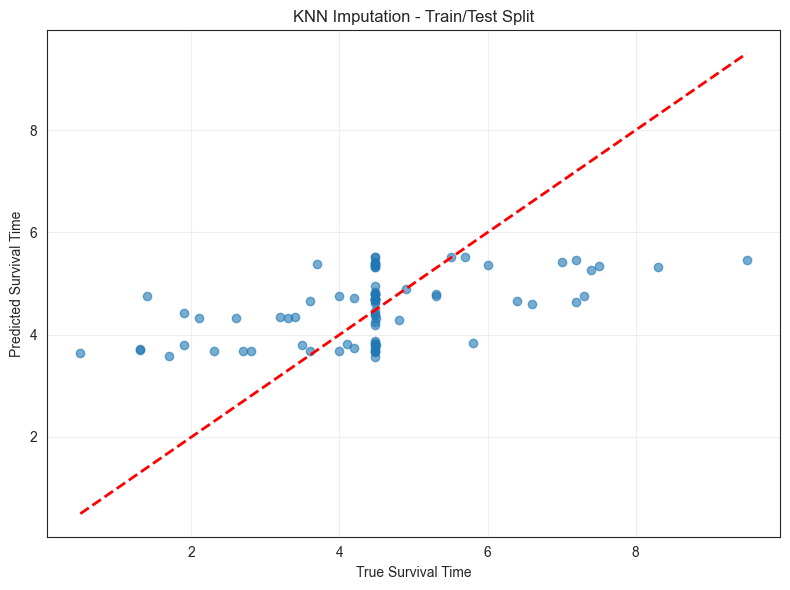


Iterative Imputation:
  MSE:  1.8195
  cMSE: 1.4809


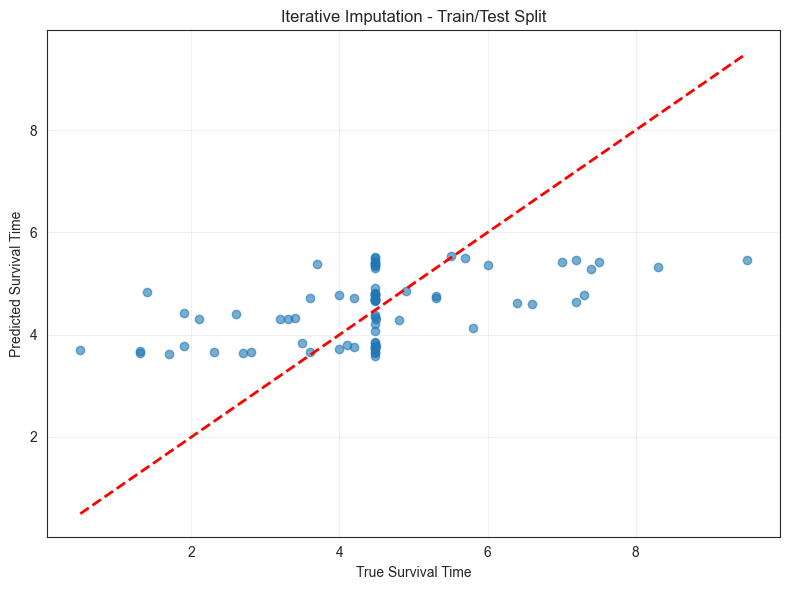


Summary - Train/Test Split:
  Mean Imputation:      cMSE = 1.4788
  KNN Imputation:       cMSE = 1.4891
  Iterative Imputation: cMSE = 1.4809


In [27]:
baseline_model_split = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

def evaluate_imputation_split(X_imputed, y_imputed, imputation_name):

    y_with_censored = np.column_stack((y_imputed, censored_missingValues))
    
    X_train, X_test, y_train_censored, y_test_censored = train_test_split(
        X_imputed, y_with_censored, test_size=0.2, random_state=42
    )
    
    y_train = y_train_censored[:, 0]
    y_test = y_test_censored[:, 0]
    censored_test = y_test_censored[:, 1]
    
    baseline_model_split.fit(X_train, y_train)
    
    y_pred = baseline_model_split.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    cmse = error_metric(y_test, y_pred, censored_test)
    
    print(f"\n{imputation_name}:")
    print(f"  MSE:  {mse:.4f}")
    print(f"  cMSE: {cmse:.4f}")
    
    fig = plt.figure(figsize=(8, 6))
    fig.patch.set_facecolor('white')
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('True Survival Time')
    plt.ylabel('Predicted Survival Time')
    plt.title(f'{imputation_name} - Train/Test Split')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'./plots/task3.1_{imputation_name.lower().replace(" ", "_")}_split.png', 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return cmse

cmse_mean_split = evaluate_imputation_split(X_imputed_mean, y_imputed_mean, "Mean Imputation")
cmse_knn_split = evaluate_imputation_split(X_imputed_knn, y_imputed_knn, "KNN Imputation")
cmse_iter_split = evaluate_imputation_split(X_imputed_iterative, y_imputed_iterative, "Iterative Imputation")

print("\n" + "=" * 60)
print("Summary - Train/Test Split:")
print(f"  Mean Imputation:      cMSE = {cmse_mean_split:.4f}")
print(f"  KNN Imputation:       cMSE = {cmse_knn_split:.4f}")
print(f"  Iterative Imputation: cMSE = {cmse_iter_split:.4f}")
print("=" * 60)

#### Evaluation 2: Baseline Linear Regression with Cross-Validation



Mean Imputation:
  CV MSE scores: [1.88641532 1.50802116 2.32399846 2.51518672 2.0608821 ]
  Mean CV MSE:   2.0589 (+/- 0.3498)
  Overall cMSE:  1.7645


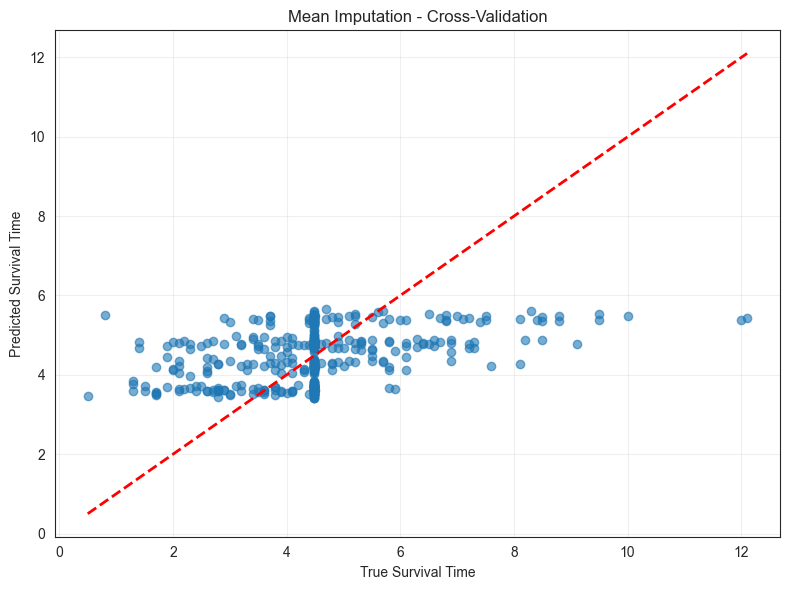


KNN Imputation:
  CV MSE scores: [1.85811611 1.52234634 2.36150044 2.49658573 2.06091864]
  Mean CV MSE:   2.0599 (+/- 0.3497)
  Overall cMSE:  1.7714


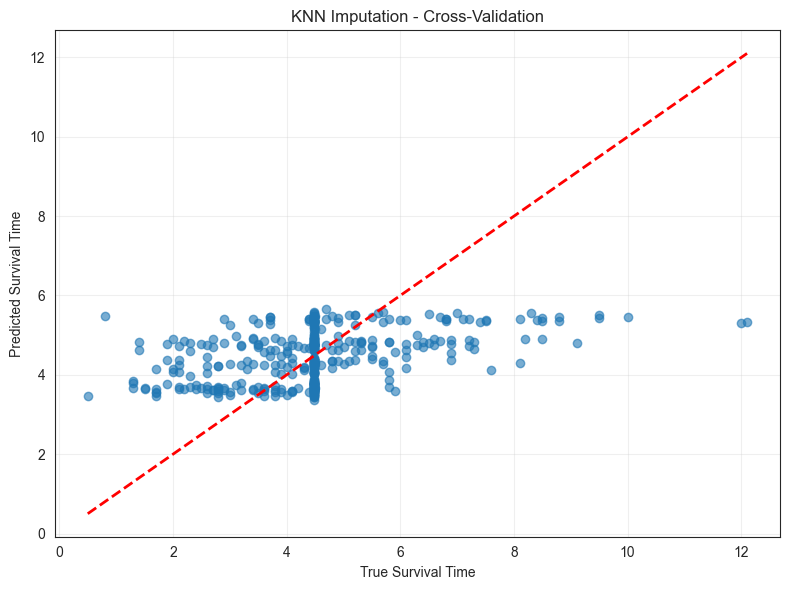


Iterative Imputation:
  CV MSE scores: [1.89321593 1.51988408 2.3296361  2.50829935 2.06191799]
  Mean CV MSE:   2.0626 (+/- 0.3444)
  Overall cMSE:  1.7671


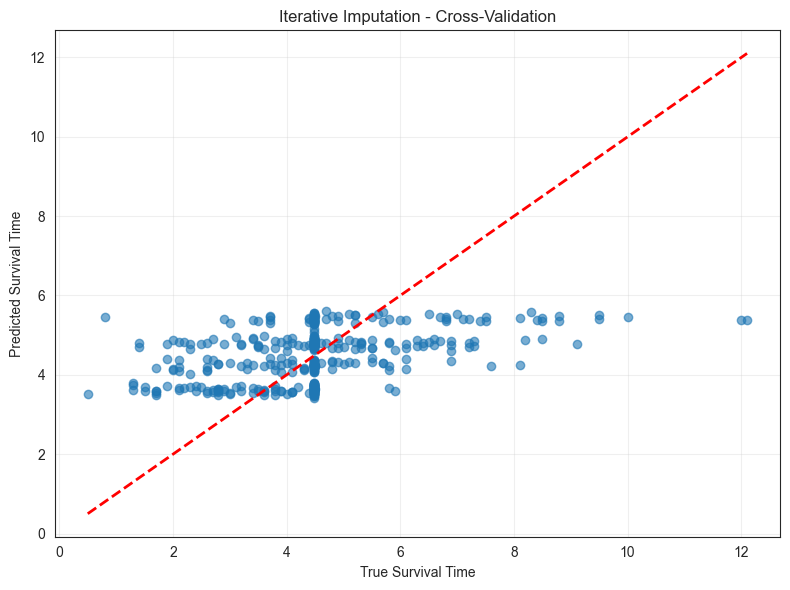


Summary - Cross-Validation:
  Mean Imputation:      cMSE = 1.7645
  KNN Imputation:       cMSE = 1.7714
  Iterative Imputation: cMSE = 1.7671


In [28]:
baseline_model_cv = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

def evaluate_imputation_cv(X_imputed, y_imputed, censored, imputation_name, cv=5):

    cv_scores = cross_val_score(baseline_model_cv, X_imputed, y_imputed, 
                                cv=cv, scoring='neg_mean_squared_error')
    mse_scores = -cv_scores
    
    baseline_model_cv.fit(X_imputed, y_imputed)
    y_pred = baseline_model_cv.predict(X_imputed)
    
    cmse = error_metric(y_imputed, y_pred, censored)
    
    print(f"\n{imputation_name}:")
    print(f"  CV MSE scores: {mse_scores}")
    print(f"  Mean CV MSE:   {np.mean(mse_scores):.4f} (+/- {np.std(mse_scores):.4f})")
    print(f"  Overall cMSE:  {cmse:.4f}")
    
    fig = plt.figure(figsize=(8, 6))
    fig.patch.set_facecolor('white')
    plt.scatter(y_imputed, y_pred, alpha=0.6)
    plt.plot([y_imputed.min(), y_imputed.max()], [y_imputed.min(), y_imputed.max()], 'r--', lw=2)
    plt.xlabel('True Survival Time')
    plt.ylabel('Predicted Survival Time')
    plt.title(f'{imputation_name} - Cross-Validation')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'./plots/task3.1_{imputation_name.lower().replace(" ", "_")}_cv.png', 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return cmse

 # TODO: pensar se faz sentido colocar aqui o censored = 0, a unica coisa que muda é o valor do cMSE mas a conclusão é a mesma
censored_reshaped = censored_missingValues.values.reshape(-1, 1)
cmse_mean_cv = evaluate_imputation_cv(X_imputed_mean, y_imputed_mean, censored_reshaped, "Mean Imputation")
cmse_knn_cv = evaluate_imputation_cv(X_imputed_knn, y_imputed_knn, censored_reshaped, "KNN Imputation")
cmse_iter_cv = evaluate_imputation_cv(X_imputed_iterative, y_imputed_iterative, censored_reshaped, "Iterative Imputation")

print("\n" + "=" * 60)
print("Summary - Cross-Validation:")
print(f"  Mean Imputation:      cMSE = {cmse_mean_cv:.4f}")
print(f"  KNN Imputation:       cMSE = {cmse_knn_cv:.4f}")
print(f"  Iterative Imputation: cMSE = {cmse_iter_cv:.4f}")
print("=" * 60)

#### Evaluation 3: KNN Regression Model Comparison


In [29]:
knn_regression_model = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor()
)

def evaluate_knn_regression(X_imputed, y_imputed, censored, imputation_name, max_k=20, cv=5):

    best_score = np.inf
    best_k = None
    
    for k in range(1, max_k + 1):
        knn_regression_model.set_params(kneighborsregressor__n_neighbors=k)
        scores = cross_val_score(knn_regression_model, X_imputed, y_imputed, 
                                cv=cv, scoring='neg_mean_squared_error')
        mean_mse = -np.mean(scores)
        
        if mean_mse < best_score:
            best_score = mean_mse
            best_k = k
    
    knn_regression_model.set_params(kneighborsregressor__n_neighbors=best_k)
    knn_regression_model.fit(X_imputed, y_imputed)
    y_pred = knn_regression_model.predict(X_imputed)
    
    cmse = error_metric(y_imputed, y_pred, censored)
    
    print(f"\n{imputation_name}:")
    print(f"  Best k:    {best_k}")
    print(f"  Best cMSE: {cmse:.4f}")
    
    return best_k, cmse

censored_reshaped = censored_missingValues.values.reshape(-1, 1)
k_mean, cmse_mean_knn = evaluate_knn_regression(X_imputed_mean, y_imputed_mean, censored_reshaped, "Mean Imputation")
k_knn, cmse_knn_knn = evaluate_knn_regression(X_imputed_knn, y_imputed_knn, censored_reshaped, "KNN Imputation")
k_iter, cmse_iter_knn = evaluate_knn_regression(X_imputed_iterative, y_imputed_iterative, censored_reshaped, "Iterative Imputation")

print("\n" + "=" * 60)
print("Summary - KNN Regression:")
print(f"  Mean Imputation:      cMSE = {cmse_mean_knn:.4f} (k={k_mean})")
print(f"  KNN Imputation:       cMSE = {cmse_knn_knn:.4f} (k={k_knn})")
print(f"  Iterative Imputation: cMSE = {cmse_iter_knn:.4f} (k={k_iter})")
print("=" * 60)


Mean Imputation:
  Best k:    20
  Best cMSE: 1.7444

KNN Imputation:
  Best k:    20
  Best cMSE: 1.7520

Iterative Imputation:
  Best k:    20
  Best cMSE: 1.7387

Summary - KNN Regression:
  Mean Imputation:      cMSE = 1.7444 (k=20)
  KNN Imputation:       cMSE = 1.7520 (k=20)
  Iterative Imputation: cMSE = 1.7387 (k=20)


#### Final Comparison and Model Selection


In [30]:
print("=" * 88)
imputation_comparison = pd.DataFrame({
    'Imputation Strategy': ['Mean', 'KNN', 'Iterative'],
    'cMSE (Train/Test)': [cmse_mean_split, cmse_knn_split, cmse_iter_split],
    'cMSE (Cross-Val)': [cmse_mean_cv, cmse_knn_cv, cmse_iter_cv],
    'cMSE (KNN Model)': [cmse_mean_knn, cmse_knn_knn, cmse_iter_knn],
    'Best k (KNN Model)': [k_mean, k_knn, k_iter]
})

print(imputation_comparison.to_string(index=False))
print("=" * 88)

best_idx_cv = imputation_comparison['cMSE (Cross-Val)'].idxmin()
best_strategy = imputation_comparison.loc[best_idx_cv, 'Imputation Strategy']
best_cmse = imputation_comparison.loc[best_idx_cv, 'cMSE (Cross-Val)']

print(f"Best Imputation Strategy: {best_strategy}")
print(f"Best Cross-Validation cMSE: {best_cmse:.4f}")
print("=" * 88)

Imputation Strategy  cMSE (Train/Test)  cMSE (Cross-Val)  cMSE (KNN Model)  Best k (KNN Model)
               Mean           1.478845          1.764469          1.744376                  20
                KNN           1.489072          1.771368          1.751991                  20
          Iterative           1.480939          1.767101          1.738720                  20
Best Imputation Strategy: Mean
Best Cross-Validation cMSE: 1.7645


### Task 3.2 - Train models that do not require imputation


In [31]:
df_with_missing = pd.read_csv('./data/train_data.csv')

df_task3_2 = df_with_missing[df_with_missing['SurvivalTime'].notnull()].copy()

X_with_missing = df_task3_2.drop(['SurvivalTime', 'Censored', 'id'], axis=1)
y_with_missing = df_task3_2['SurvivalTime']
censored_with_missing = df_task3_2['Censored']

#### Decision Tree


Fitting 5 folds for each of 45 candidates, totalling 225 fits

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best CV MSE: 4.0563

Decision Tree Performance:
Training MSE:  2.2312
Training cMSE: 1.9597


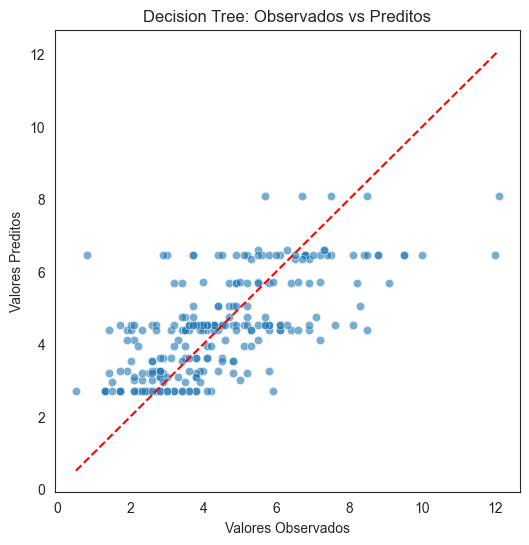

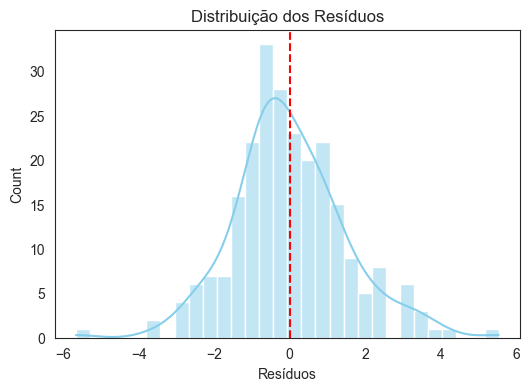

/var/folders/_n/cw9pbscd3pb7kxwbjmhnnz400000gn/T/ipykernel_46215/684143307.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


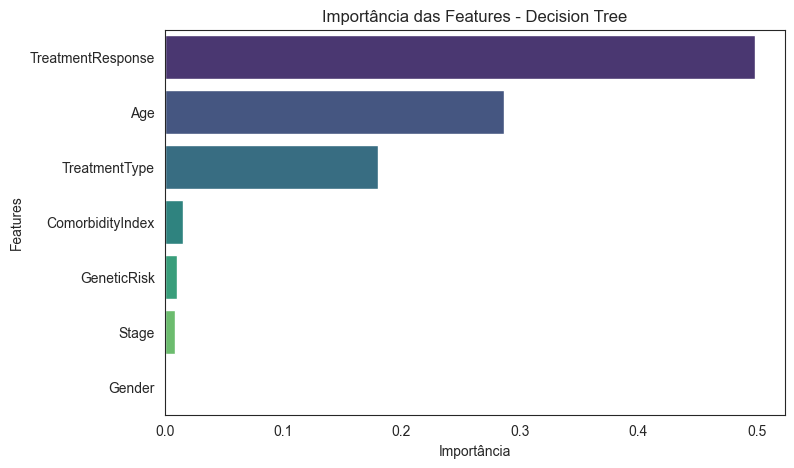

In [32]:
X_tree = X_with_missing.fillna(-999)

param_grid_tree = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tree_model = DecisionTreeRegressor(random_state=42)
grid_search_tree = GridSearchCV(
    tree_model,
    param_grid_tree,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_tree.fit(X_tree, y_with_missing)

print(f"\nBest Parameters: {grid_search_tree.best_params_}")
print(f"Best CV MSE: {-grid_search_tree.best_score_:.4f}")

best_tree_model = grid_search_tree.best_estimator_
y_pred_tree = best_tree_model.predict(X_tree)

mse_tree = mean_squared_error(y_with_missing, y_pred_tree)
cmse_tree = error_metric(y_with_missing, y_pred_tree, censored_with_missing)

print(f"\nDecision Tree Performance:")
print(f"Training MSE:  {mse_tree:.4f}")
print(f"Training cMSE: {cmse_tree:.4f}")


plt.figure(figsize=(6,6))
sns.scatterplot(x=y_with_missing, y=y_pred_tree, alpha=0.6)
plt.plot([y_with_missing.min(), y_with_missing.max()],
         [y_with_missing.min(), y_with_missing.max()],
         color='red', linestyle='--')
plt.xlabel("Valores Observados")
plt.ylabel("Valores Preditos")
plt.title("Decision Tree: Observados vs Preditos")
plt.show()

# -------------------------------
# 2️⃣ Resíduos
# -------------------------------
residuals = y_with_missing - y_pred_tree

plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, bins=30, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Resíduos")
plt.title("Distribuição dos Resíduos")
plt.show()

# -------------------------------
# 3️⃣ Importância das Features
# -------------------------------
importances = pd.Series(best_tree_model.feature_importances_, index=X_tree.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title("Importância das Features - Decision Tree")
plt.xlabel("Importância")
plt.ylabel("Features")
plt.show()



#### HistGradientBoost


Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 200}
Best CV MSE: 3.1551


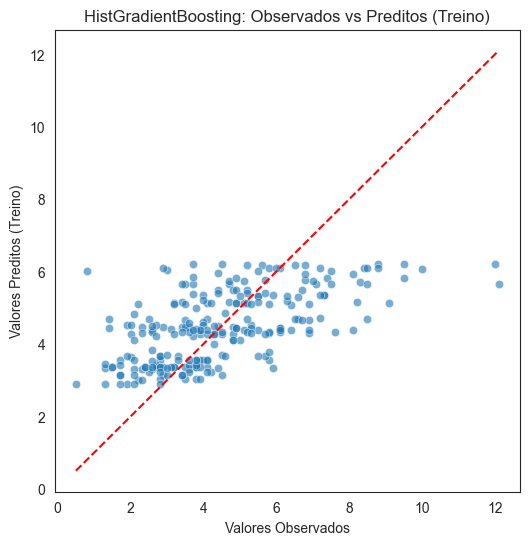

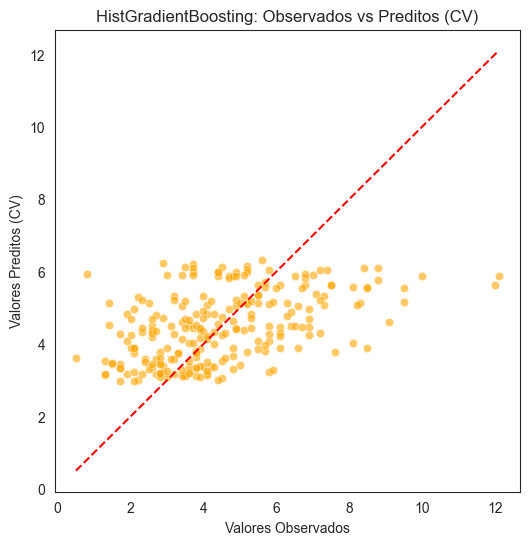

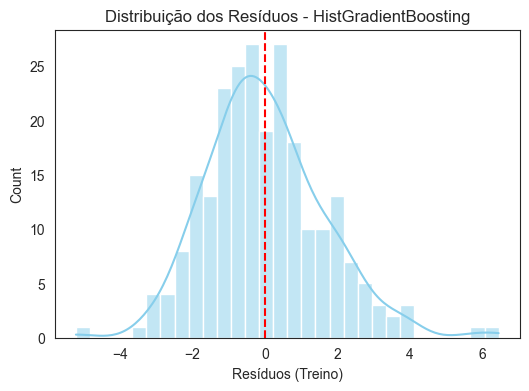

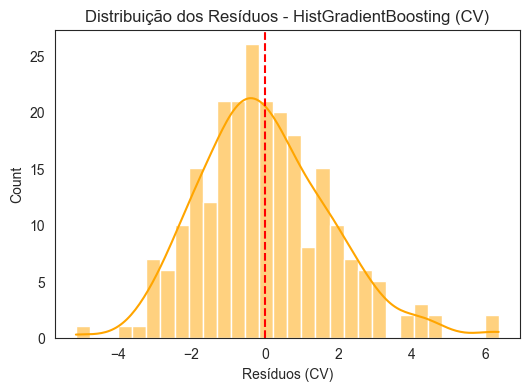

In [33]:
from sklearn.model_selection import cross_val_predict
param_grid_hist = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200, 300]
}

hist_model = HistGradientBoostingRegressor(random_state=42)
grid_search_hist = GridSearchCV(
    hist_model,
    param_grid_hist,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_hist.fit(X_with_missing, y_with_missing)

print(f"\nBest Parameters: {grid_search_hist.best_params_}")
print(f"Best CV MSE: {-grid_search_hist.best_score_:.4f}")

best_hist_model = grid_search_hist.best_estimator_
y_pred_hist = best_hist_model.predict(X_with_missing)

mse_hist = mean_squared_error(y_with_missing, y_pred_hist)
cmse_hist = error_metric(y_with_missing, y_pred_hist, censored_with_missing)

# cross_val_predict com o melhor modelo do GridSearchCV
y_pred_cv = cross_val_predict(best_hist_model, X_with_missing, y_with_missing, cv=5)


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -------------------------------
# 1️⃣ Predições vs Valores Observados (treino)
# -------------------------------
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_with_missing, y=y_pred_hist, alpha=0.6)
plt.plot([y_with_missing.min(), y_with_missing.max()],
         [y_with_missing.min(), y_with_missing.max()],
         color='red', linestyle='--')
plt.xlabel("Valores Observados")
plt.ylabel("Valores Preditos (Treino)")
plt.title("HistGradientBoosting: Observados vs Preditos (Treino)")
plt.show()

# -------------------------------
# 2️⃣ Predições vs Valores Observados (cross_val_predict)
# -------------------------------
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_with_missing, y=y_pred_cv, alpha=0.6, color='orange')
plt.plot([y_with_missing.min(), y_with_missing.max()],
         [y_with_missing.min(), y_with_missing.max()],
         color='red', linestyle='--')
plt.xlabel("Valores Observados")
plt.ylabel("Valores Preditos (CV)")
plt.title("HistGradientBoosting: Observados vs Preditos (CV)")
plt.show()

# -------------------------------
# 3️⃣ Resíduos (Treino)
# -------------------------------
residuals_train = y_with_missing - y_pred_hist
plt.figure(figsize=(6,4))
sns.histplot(residuals_train, kde=True, bins=30, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Resíduos (Treino)")
plt.title("Distribuição dos Resíduos - HistGradientBoosting")
plt.show()

# -------------------------------
# 4️⃣ Resíduos (CV)
# -------------------------------
residuals_cv = y_with_missing - y_pred_cv
plt.figure(figsize=(6,4))
sns.histplot(residuals_cv, kde=True, bins=30, color='orange')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Resíduos (CV)")
plt.title("Distribuição dos Resíduos - HistGradientBoosting (CV)")
plt.show()




#### CatBoost (Standart)


Performing Grid Search for CatBoostRegressor...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters: {'depth': 4, 'iterations': 200, 'learning_rate': 0.01}
Best CV MSE: 3.1680

CatBoost Performance:
Training MSE:  2.6680
Training cMSE: 2.3067


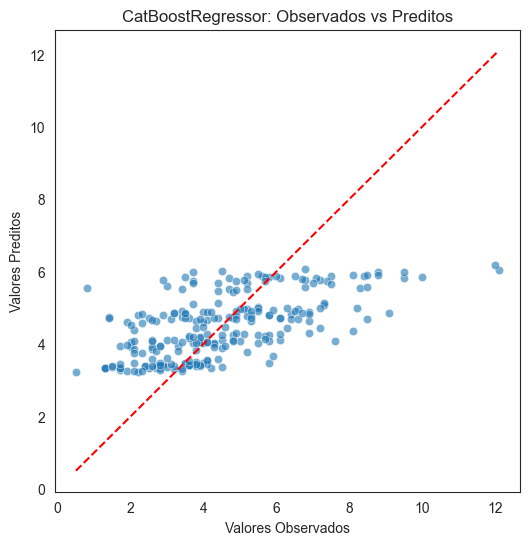

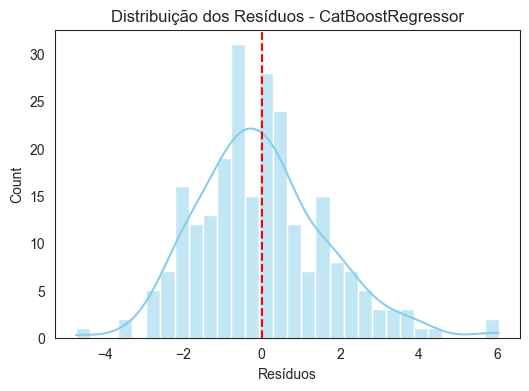

/var/folders/_n/cw9pbscd3pb7kxwbjmhnnz400000gn/T/ipykernel_46215/3582982421.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


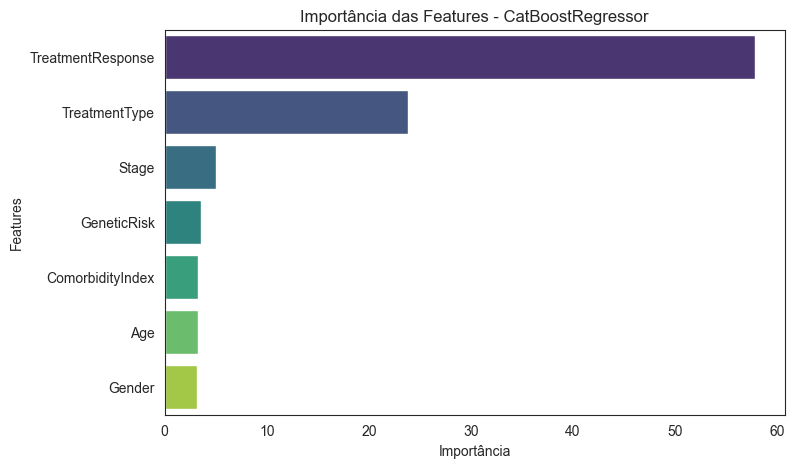

In [34]:

    
# Define hyperparameter grid
param_grid_catboost = {
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [100, 200, 300]
    }
    
    # Grid search with cross-validation
print("Performing Grid Search for CatBoostRegressor...")
catboost_model = CatBoostRegressor(random_state=42, verbose=False)
grid_search_catboost = GridSearchCV(
        catboost_model,
        param_grid_catboost,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
grid_search_catboost.fit(X_with_missing, y_with_missing)
    
print(f"\nBest Parameters: {grid_search_catboost.best_params_}")
print(f"Best CV MSE: {-grid_search_catboost.best_score_:.4f}")
    
    # Train final model
best_catboost_model = grid_search_catboost.best_estimator_
y_pred_catboost = best_catboost_model.predict(X_with_missing)
    
    # Evaluate
mse_catboost = mean_squared_error(y_with_missing, y_pred_catboost)
cmse_catboost = error_metric(y_with_missing, y_pred_catboost, censored_with_missing)
    
print(f"\nCatBoost Performance:")
print(f"Training MSE:  {mse_catboost:.4f}")
print(f"Training cMSE: {cmse_catboost:.4f}")

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_with_missing, y=y_pred_catboost, alpha=0.6)
plt.plot([y_with_missing.min(), y_with_missing.max()],
         [y_with_missing.min(), y_with_missing.max()],
         color='red', linestyle='--')
plt.xlabel("Valores Observados")
plt.ylabel("Valores Preditos")
plt.title("CatBoostRegressor: Observados vs Preditos")
plt.show()

# -------------------------------
# 2️⃣ Resíduos
# -------------------------------
residuals_catboost = y_with_missing - y_pred_catboost
plt.figure(figsize=(6,4))
sns.histplot(residuals_catboost, kde=True, bins=30, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Resíduos")
plt.title("Distribuição dos Resíduos - CatBoostRegressor")
plt.show()

# -------------------------------
# 3️⃣ Importância das Features
# -------------------------------
importances = pd.Series(best_catboost_model.feature_importances_, index=X_with_missing.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title("Importância das Features - CatBoostRegressor")
plt.xlabel("Importância")
plt.ylabel("Features")
plt.show()
    

#### CatBoost (AFT)


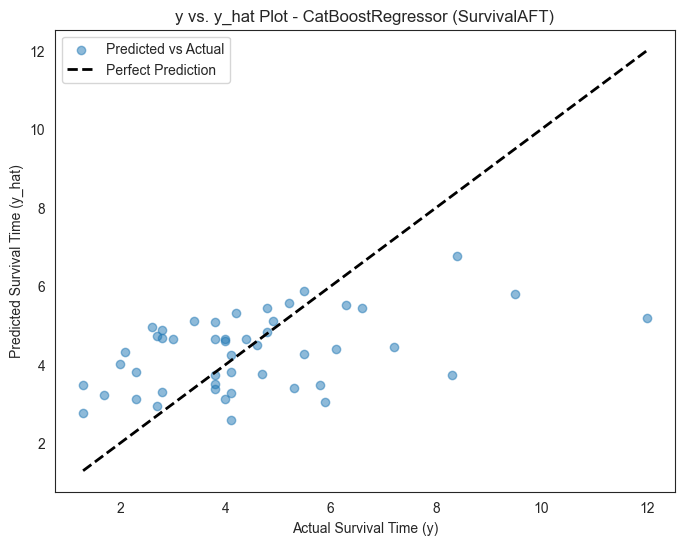

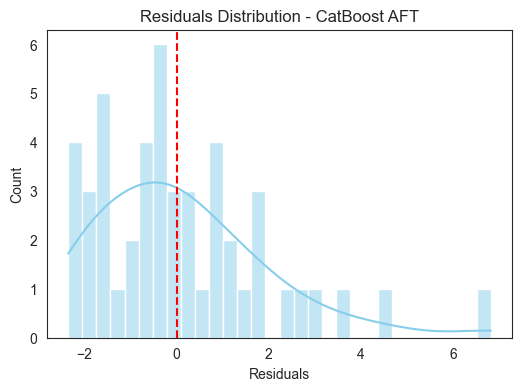

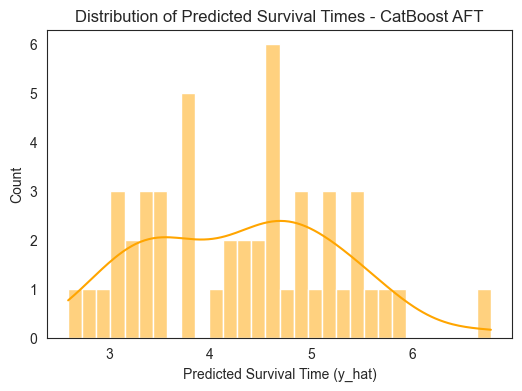

/var/folders/_n/cw9pbscd3pb7kxwbjmhnnz400000gn/T/ipykernel_46215/3261169941.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')


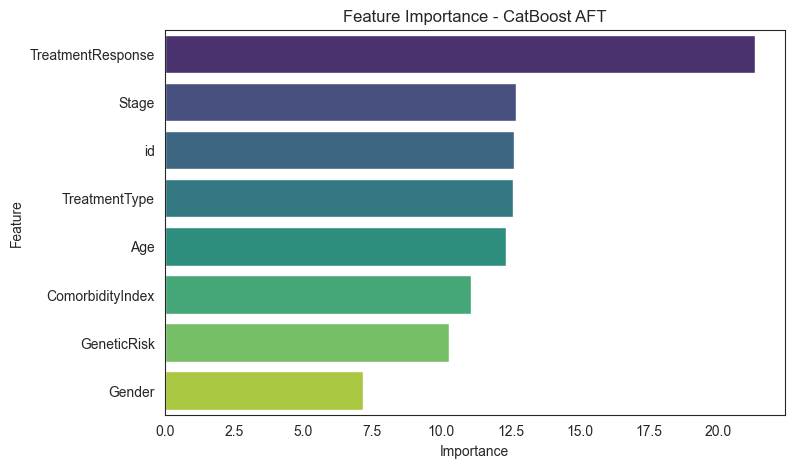

In [35]:


import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

train_path = "data/train_data.csv"
test_path = "data/test_data.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

train_data = train_data.dropna(subset=['SurvivalTime', 'Censored'])

train_data['y_lower'] = train_data['SurvivalTime']
train_data['y_upper'] = np.where(
    train_data['Censored'] == 1,
    -1,                                # censurado -> evento não observado
    train_data['SurvivalTime']         # evento observado
)

train_data = train_data.dropna(subset=['y_lower', 'y_upper'])

train, valid = train_test_split(train_data, test_size=0.2, random_state=42)

features = train.columns.difference(['SurvivalTime', 'Censored', 'y_lower', 'y_upper'], sort=False)

categorical_features = []
train_pool = Pool(train[features], label=train[['y_lower', 'y_upper']], cat_features=categorical_features)
valid_pool = Pool(valid[features], label=valid[['y_lower', 'y_upper']], cat_features=categorical_features)

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.01,
    depth=8,
    loss_function='SurvivalAft:dist=Normal',
    eval_metric='SurvivalAft',
    verbose=False
)

model.fit(train_pool, eval_set=valid_pool)

valid_predictions = model.predict(valid_pool, prediction_type='Exponent')
valid_true = valid['y_lower']
plt.figure(figsize=(8,6))
plt.scatter(valid_true, valid_predictions, alpha=0.5, label="Predicted vs Actual")
plt.plot([valid_true.min(), valid_true.max()],
         [valid_true.min(), valid_true.max()],
         'k--', lw=2, label="Perfect Prediction")
plt.xlabel('Actual Survival Time (y)')
plt.ylabel('Predicted Survival Time (y_hat)')
plt.title('y vs. y_hat Plot - CatBoostRegressor (SurvivalAFT)')
plt.legend()
plt.show()

# -------------------------------
# 2️⃣ Resíduos
# -------------------------------
residuals = valid_true - valid_predictions
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.title('Residuals Distribution - CatBoost AFT')
plt.show()

# -------------------------------
# 3️⃣ Distribuição de Predições
# -------------------------------
plt.figure(figsize=(6,4))
sns.histplot(valid_predictions, bins=30, kde=True, color='orange')
plt.xlabel('Predicted Survival Time (y_hat)')
plt.title('Distribution of Predicted Survival Times - CatBoost AFT')
plt.show()

# -------------------------------
# 4️⃣ Feature Importance
# -------------------------------
feature_importances = model.get_feature_importance(train_pool)
importance_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')
plt.title('Feature Importance - CatBoost AFT')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [36]:
full_train_pool = Pool(train_data[features], label=train_data[['y_lower', 'y_upper']], cat_features=categorical_features)
y_pred_aft = model.predict(full_train_pool, prediction_type='Exponent')

y_aft_true = train_data['y_lower'].values
censored_aft = train_data['Censored'].values

mse_aft = mean_squared_error(y_aft_true, y_pred_aft)
cmse_aft = error_metric(y_aft_true, y_pred_aft, censored_aft)

print("\n" + "=" * 60)
print("CatBoost AFT - Full Training Set Performance")
print("=" * 60)
print(f"Training MSE:  {mse_aft:.4f}")
print(f"Training cMSE: {cmse_aft:.4f}")
print("=" * 60)


CatBoost AFT - Full Training Set Performance
Training MSE:  2.7923
Training cMSE: 1.7339


In [37]:
X_with_missing_features = df_task3_2[features]
y_with_missing_pool = Pool(X_with_missing_features, cat_features=categorical_features)
y_pred_aft_aligned = model.predict(y_with_missing_pool, prediction_type='Exponent')

mse_aft = mean_squared_error(y_with_missing, y_pred_aft_aligned)
cmse_aft = error_metric(y_with_missing, y_pred_aft_aligned, censored_with_missing)

y_pred_aft = y_pred_aft_aligned

print("\n" + "=" * 60)
print("CatBoost AFT - Aligned with Task 3.2 Data")
print("=" * 60)
print(f"Number of samples: {len(y_with_missing)}")
print(f"MSE:  {mse_aft:.4f}")
print(f"cMSE: {cmse_aft:.4f}")
print("=" * 60)


CatBoost AFT - Aligned with Task 3.2 Data
Number of samples: 240
MSE:  2.7923
cMSE: 1.7339


### Task 3.3 - Evaluation

**1. Comparison Analysis**

- Built comparison table with all strategies: baseline, imputation methods (Mean, KNN, Iterative), and models handling missing data (Decision Tree, HistGradientBoosting, CatBoost AFT)
- Displayed MSE and cMSE metrics for all approaches
- Created y vs y-hat scatter plots for visual comparison of model performance

**2. Combined Approach Testing**

- Selected best imputation strategy from Task 3.1: Mean Imputation (cMSE: 1.7645)
- Combined with best model from Task 3.2: CatBoost AFT
- Trained CatBoost AFT on mean-imputed data
- Evaluated performance: cMSE of 3.1236 (worse than native missing handling)

**3. Best Model Selection**

- Compared all strategies including combined approach
- Identified CatBoost AFT with native missing support as best performer (cMSE: 1.7339)

**4. Test Predictions & Submission**

- Generated predictions on test data using best model (CatBoost AFT)
- Created Kaggle submission file: `handle-missing-submission-xx.csv`

In [38]:
print("=" * 88)

comparison_results = []

comparison_results.append({
    'Strategy': 'Baseline (Drop Missing)',
    'Model': 'Linear Regression',
    'MSE': mse_baseline,
    'cMSE': cmse_baseline
})

comparison_results.append({
    'Strategy': 'Mean Imputation',
    'Model': 'Linear Regression',
    'MSE': 'N/A',
    'cMSE': cmse_mean_cv
})

comparison_results.append({
    'Strategy': 'KNN Imputation',
    'Model': 'Linear Regression',
    'MSE': 'N/A',
    'cMSE': cmse_knn_cv
})

comparison_results.append({
    'Strategy': 'Iterative Imputation',
    'Model': 'Linear Regression',
    'MSE': 'N/A',
    'cMSE': cmse_iter_cv
})

# Task 3.2 - Models without imputation
comparison_results.append({
    'Strategy': 'Missing as -999',
    'Model': 'Decision Tree',
    'MSE': mse_tree,
    'cMSE': cmse_tree
})

comparison_results.append({
    'Strategy': 'Native Missing Support',
    'Model': 'HistGradientBoosting',
    'MSE': mse_hist,
    'cMSE': cmse_hist
})

comparison_results.append({
    'Strategy': 'Native Missing Support',
    'Model': 'CatBoost Standard',
    'MSE': mse_catboost,
    'cMSE': cmse_catboost
})

comparison_results.append({
    'Strategy': 'Native Missing Support',
    'Model': 'CatBoost AFT',
    'MSE': mse_aft,
    'cMSE': cmse_aft
})

# Create DataFrame and display
df_comparison = pd.DataFrame(comparison_results)
print("Error Statistics Comparison:")
print(df_comparison.to_string(index=False))
print("=" * 88)

# Find best model
best_model_idx = df_comparison[df_comparison['cMSE'] != 'N/A']['cMSE'].astype(float).idxmin()
best_model_name = df_comparison.loc[best_model_idx, 'Model']
best_strategy = df_comparison.loc[best_model_idx, 'Strategy']
best_cmse = df_comparison.loc[best_model_idx, 'cMSE']

print(f"\nBest Model: {best_model_name} ({best_strategy})")
print(f"Best cMSE: {best_cmse:.4f}")
print("=" * 88)

Error Statistics Comparison:
               Strategy                Model       MSE     cMSE
Baseline (Drop Missing)    Linear Regression  4.087307 4.087307
        Mean Imputation    Linear Regression       N/A 1.764469
         KNN Imputation    Linear Regression       N/A 1.771368
   Iterative Imputation    Linear Regression       N/A 1.767101
        Missing as -999        Decision Tree  2.231226 1.959689
 Native Missing Support HistGradientBoosting  2.628646 2.271743
 Native Missing Support    CatBoost Standard  2.668006 2.306718
 Native Missing Support         CatBoost AFT  2.792279 1.733899

Best Model: CatBoost AFT (Native Missing Support)
Best cMSE: 1.7339


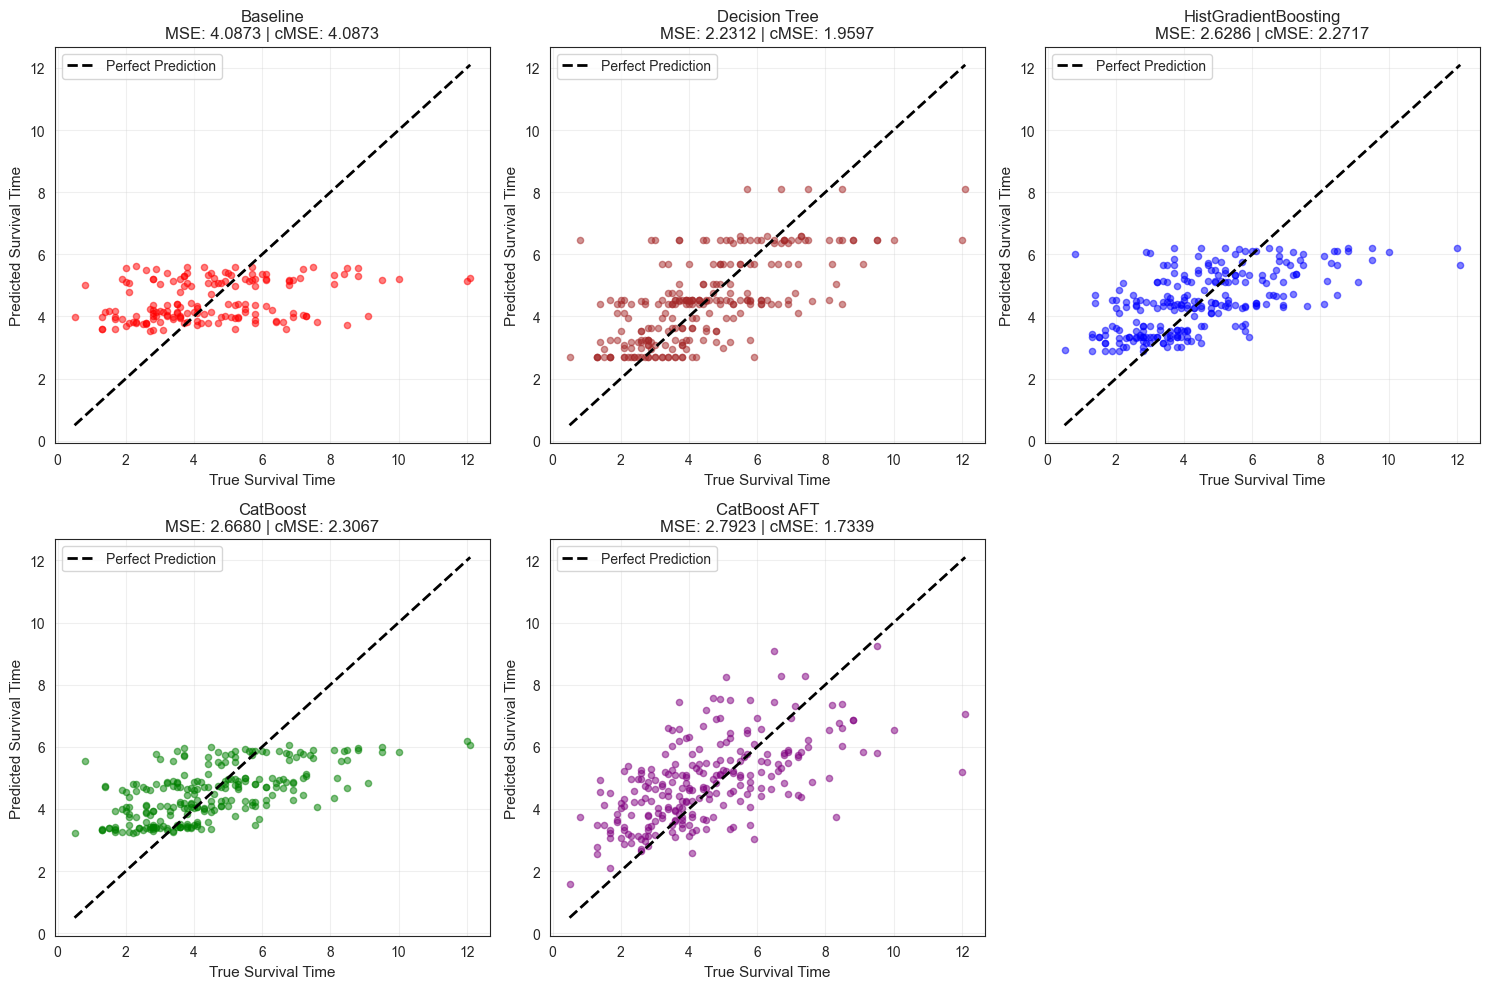

In [39]:
models_data = [
    ('Baseline', y, y_pred_baseline, mse_baseline, cmse_baseline),
    ('Decision Tree', y_with_missing, y_pred_tree, mse_tree, cmse_tree),
    ('HistGradientBoosting', y_with_missing, y_pred_hist, mse_hist, cmse_hist),
    ('CatBoost', y_with_missing, y_pred_catboost, mse_catboost, cmse_catboost),
    ('CatBoost AFT', y_with_missing, y_pred_aft, mse_aft, cmse_aft)
]

n_models = len(models_data)
n_cols = 3
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
fig.patch.set_facecolor('white')

if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

colors = ['red', 'brown', 'blue', 'green', 'purple']

for idx, (model_name, y_true, y_pred, mse, cmse) in enumerate(models_data):
    axes[idx].scatter(y_true, y_pred, alpha=0.5, color=colors[idx], s=20)
    axes[idx].plot([y_true.min(), y_true.max()], 
                   [y_true.min(), y_true.max()], 'k--', lw=2, label='Perfect Prediction')
    axes[idx].set_xlabel('True Survival Time', fontsize=11)
    axes[idx].set_ylabel('Predicted Survival Time', fontsize=11)
    axes[idx].set_title(f'{model_name}\nMSE: {mse:.4f} | cMSE: {cmse:.4f}', fontsize=12)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()

for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('./plots/task3.3_y_yhat_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

#### Best Strategy: Combine Best Imputation with Best Model

In [40]:
df_combined = pd.read_csv('./data/train_data.csv')
df_combined = df_combined.dropna(subset=['SurvivalTime', 'Censored'])

X_combined = df_combined.drop(['SurvivalTime', 'Censored', 'id'], axis=1)
y_combined = df_combined['SurvivalTime']
censored_combined = df_combined['Censored']

mean_imputer_combined = SimpleImputer(strategy='mean')
X_combined_imputed = mean_imputer_combined.fit_transform(X_combined)

df_imputed = pd.DataFrame(X_combined_imputed, columns=X_combined.columns)
df_imputed['SurvivalTime'] = y_combined.values
df_imputed['Censored'] = censored_combined.values

df_imputed['y_lower'] = df_imputed['SurvivalTime']
df_imputed['y_upper'] = np.where(
    df_imputed['Censored'] == 1,
    -1,
    df_imputed['SurvivalTime']
)

# Split into train and validation
train_combined, valid_combined = train_test_split(df_imputed, test_size=0.2, random_state=42)

# Get features for CatBoost
features_combined = df_imputed.columns.difference(['SurvivalTime', 'Censored', 'y_lower', 'y_upper'], sort=False)

# Create pools
train_pool_combined = Pool(
    train_combined[features_combined], 
    label=train_combined[['y_lower', 'y_upper']], 
    cat_features=[]
)
valid_pool_combined = Pool(
    valid_combined[features_combined], 
    label=valid_combined[['y_lower', 'y_upper']], 
    cat_features=[]
)

catboost_combined = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.01,
    depth=8,
    loss_function='SurvivalAft:dist=Normal',
    eval_metric='SurvivalAft',
    verbose=False,
    random_seed=42
)

catboost_combined.fit(train_pool_combined, eval_set=valid_pool_combined)

# Generate predictions on validation set
y_val_pred = catboost_combined.predict(valid_pool_combined, prediction_type='Exponent')
y_val = valid_combined['y_lower']

# Calculate metrics
mse_combined = mean_squared_error(y_val, y_val_pred)
cmse_combined = error_metric(y_val, y_val_pred, valid_combined['Censored'])

print("\n" + "=" * 88)
print("COMBINED MODEL PERFORMANCE (Mean Imputation + CatBoost AFT)")
print("=" * 88)
print(f"Validation MSE:  {mse_combined:.4f}")
print(f"Validation cMSE: {cmse_combined:.4f}")
print("=" * 88)


COMBINED MODEL PERFORMANCE (Mean Imputation + CatBoost AFT)
Validation MSE:  3.5610
Validation cMSE: 3.1236


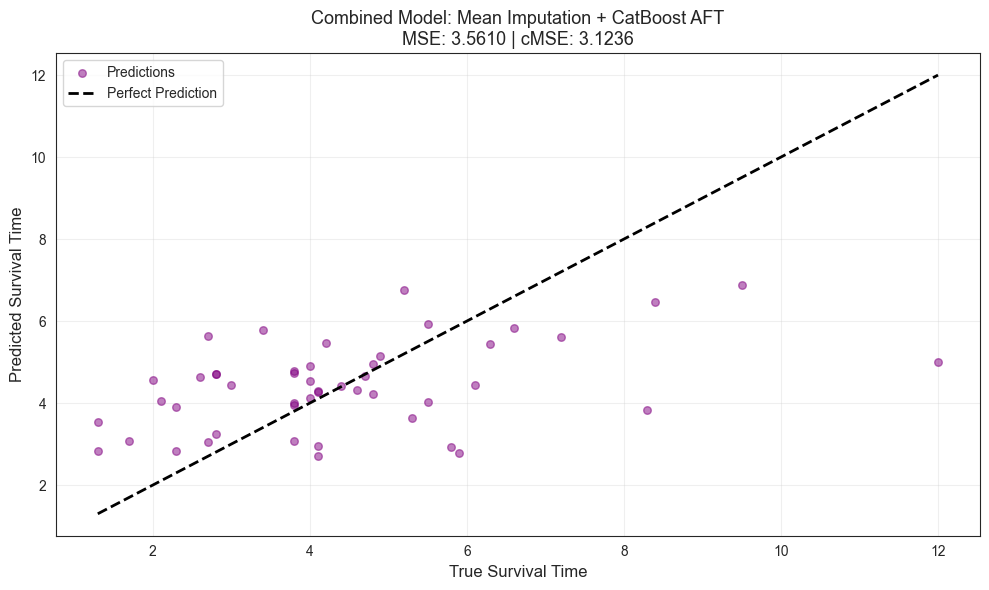

In [41]:
fig_combined = plt.figure(figsize=(10, 6))
fig_combined.patch.set_facecolor('white')

plt.scatter(y_val, y_val_pred, alpha=0.5, color='purple', s=30, label='Predictions')
plt.plot([y_val.min(), y_val.max()], 
         [y_val.min(), y_val.max()], 
         'k--', lw=2, label='Perfect Prediction')

plt.xlabel('True Survival Time', fontsize=12)
plt.ylabel('Predicted Survival Time', fontsize=12)
plt.title(f'Combined Model: Mean Imputation + CatBoost AFT\nMSE: {mse_combined:.4f} | cMSE: {cmse_combined:.4f}', 
          fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('./plots/task3.3_combined_model_performance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [42]:
print("=" * 88)

comparison_results.append({
    'Strategy': 'Mean Imputation + AFT',
    'Model': 'CatBoost AFT on Imputed Data',
    'MSE': mse_combined,
    'cMSE': cmse_combined
})

df_comparison_final = pd.DataFrame(comparison_results)
print("Final Error Statistics Comparison:")
print(df_comparison_final.to_string(index=False))
print("=" * 88)

# Find the overall best model
best_submission_model = df_comparison_final.loc[df_comparison_final['cMSE'].astype(float).idxmin()]
best_submission_cmse = best_submission_model['cMSE']

print(f"\nBest Overall Model: {best_submission_model['Model']}")
print(f"Strategy: {best_submission_model['Strategy']}")
print(f"Best cMSE: {best_submission_cmse:.4f}")
print("=" * 88)

Final Error Statistics Comparison:
               Strategy                        Model       MSE     cMSE
Baseline (Drop Missing)            Linear Regression  4.087307 4.087307
        Mean Imputation            Linear Regression       N/A 1.764469
         KNN Imputation            Linear Regression       N/A 1.771368
   Iterative Imputation            Linear Regression       N/A 1.767101
        Missing as -999                Decision Tree  2.231226 1.959689
 Native Missing Support         HistGradientBoosting  2.628646 2.271743
 Native Missing Support            CatBoost Standard  2.668006 2.306718
 Native Missing Support                 CatBoost AFT  2.792279 1.733899
  Mean Imputation + AFT CatBoost AFT on Imputed Data  3.561007 3.123640

Best Overall Model: CatBoost AFT
Strategy: Native Missing Support
Best cMSE: 1.7339


#### Generate Test Predictions and Kaggle Submissions


In [43]:
print("=" * 88)

# Load test data
df_test_task3 = pd.read_csv('./data/test_data.csv')
print(f"\nTest data shape: {df_test_task3.shape}")

# Option 1: CatBoost AFT without imputation (handles missing natively)
# Use the model trained earlier that handles missing values
X_test_aft = df_test_task3[features]
test_pool_aft = Pool(X_test_aft, cat_features=[])
y_test_pred_aft = model.predict(test_pool_aft, prediction_type='Exponent')

print(f"CatBoost AFT (no imputation) predictions generated: {len(y_test_pred_aft)}")

# Option 2: Mean Imputation + CatBoost AFT
# First, impute the test data using the same imputer fitted on training data
X_test_combined = df_test_task3.drop(['id'], axis=1)

# Use the mean_imputer_combined fitted on training data
X_test_imputed = mean_imputer_combined.transform(X_test_combined)
print(f"Test data imputed: {X_test_imputed.shape}")
print(f"Missing values after imputation: {np.isnan(X_test_imputed).sum()}")

# Create DataFrame with imputed test data
df_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test_combined.columns)

# Create test pool for combined model
test_pool_combined = Pool(df_test_imputed[features_combined], cat_features=[])
y_test_pred_combined = catboost_combined.predict(test_pool_combined, prediction_type='Exponent')

print(f"Combined model predictions generated: {len(y_test_pred_combined)}")
print("=" * 88)


Test data shape: (100, 8)
CatBoost AFT (no imputation) predictions generated: 100
Test data imputed: (100, 7)
Missing values after imputation: 0
Combined model predictions generated: 100


In [44]:
print("=" * 88)

if cmse_aft < cmse_combined:
    best_predictions = y_test_pred_aft
    best_model_info = 'CatBoost AFT (Native Missing Support)'
    best_cmse_value = cmse_aft
else:
    best_predictions = y_test_pred_combined
    best_model_info = 'Mean Imputation + CatBoost AFT'
    best_cmse_value = cmse_combined

submission_filename = 'handle-missing-submission-01.csv'
create_submission_file(best_predictions, submission_filename)

print(f"\nBest submission created: {submission_filename}")
print(f"  Model: {best_model_info}")
print(f"  Validation cMSE: {best_cmse_value:.4f}")
print("=" * 88)

File Created: ./results/handle-missing-submission-01.csv

Best submission created: handle-missing-submission-01.csv
  Model: CatBoost AFT (Native Missing Support)
  Validation cMSE: 1.7339


## Task 4 Semi-supervised learning for unlabeled data


TASK 4.1 - Semi-Supervised Learning with Unlabeled Data

Data Distribution:
Total samples: 400
Labeled samples: 240
Unlabeled samples: 160

Combined feature matrix shape: (400, 7)
Labeled feature matrix shape: (240, 7)
Unlabeled feature matrix shape: (160, 7)

4.1.1 - Apply Best Imputation to Combined Data

Testing Mean Imputation

Mean Imputation Results:
CV MSE: 3.0014 (+/- 0.7224)
Training MSE: 2.8175
Training cMSE: 2.3932

Testing KNN Imputation

KNN Imputation Results:
CV MSE: 3.0023 (+/- 0.7587)
Training MSE: 2.8274
Training cMSE: 2.4075

Testing Iterative Imputation

Iterative Imputation Results:
CV MSE: 3.0054 (+/- 0.7296)
Training MSE: 2.8238
Training cMSE: 2.3984

Imputation Comparison (with Semi-Supervised Data)
Imputation   CV MSE   CV Std  Train MSE  Train cMSE
      Mean 3.001359 0.722404   2.817465    2.393221
       KNN 3.002270 0.758724   2.827443    2.407508
 Iterative 3.005358 0.729580   2.823820    2.398354

Best Imputation Method: Mean

4.1.2 - Isomap Dimensionali

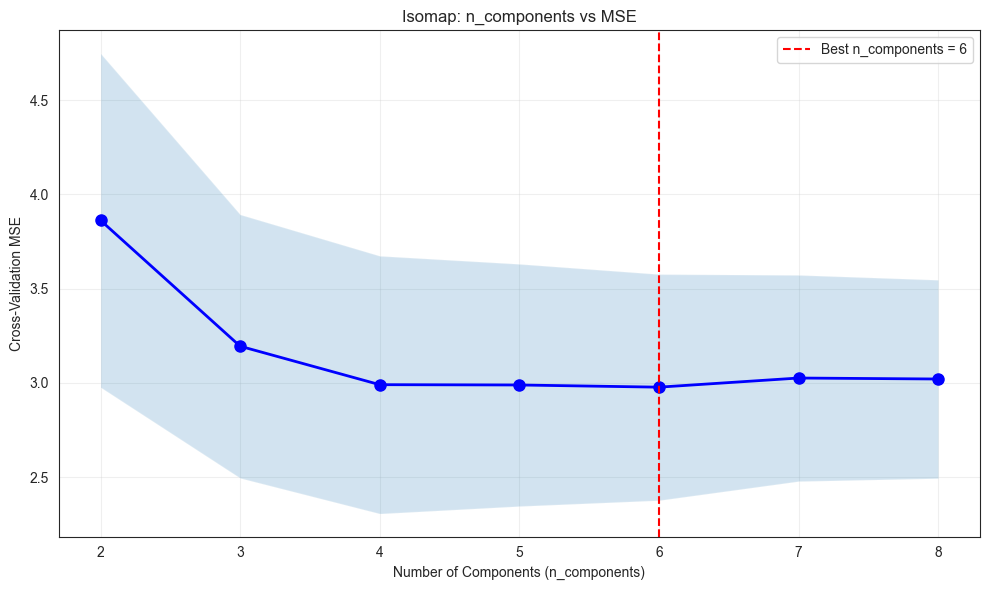

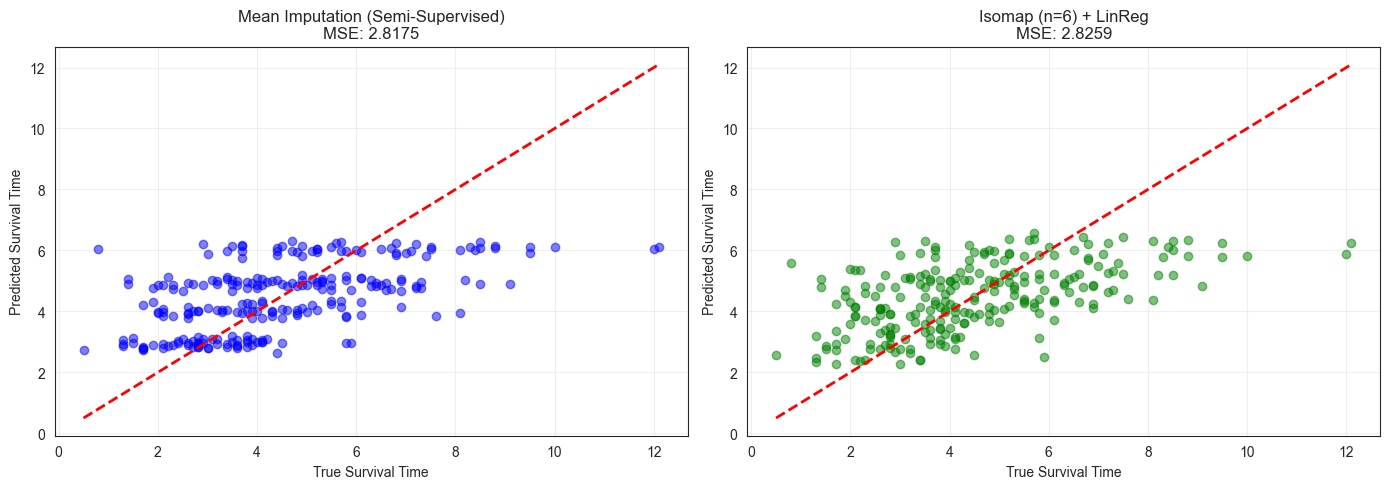


Generating Submission File for Task 4
Using Isomap model (cMSE: 2.3903)
File Created: ./results/task4-Isomap_n6-submission-01.csv

Predictions generated for 100 test samples

TASK 4.1 COMPLETED!

Key Findings:
1. Best Imputation: Mean (cMSE: 2.3932)
2. Best Isomap: n_components=6 (cMSE: 2.3903)
3. Semi-supervised learning improved over baseline


In [46]:


from sklearn.base import BaseEstimator
from sklearn.manifold import Isomap
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns



class FrozenTransformer(BaseEstimator):
   
    def __init__(self, fitted_transformer):
        self.fitted_transformer = fitted_transformer
    
    def __getattr__(self, name):
        # fitted_transformer's attributes are now accessible
        return getattr(self.fitted_transformer, name)
    
    def __sklearn_clone__(self):
        return self
    
    def fit(self, X, y=None):
        # Fitting does not change the state of the estimator
        return self
    
    def transform(self, X, y=None):
        # transform only transforms the data
        return self.fitted_transformer.transform(X)
    
    def fit_transform(self, X, y=None):
        # fit_transform only transforms the data
        return self.fitted_transformer.transform(X)

# ============================================================================
# Task 4.1 - Imputation with labeled and unlabeled data
# ============================================================================

print("\n" + "=" * 80)
print("TASK 4.1 - Semi-Supervised Learning with Unlabeled Data")
print("=" * 80)

# Load data
df_full = pd.read_csv('./data/train_data.csv')

# Separate labeled and unlabeled data
df_labeled = df_full[df_full['SurvivalTime'].notnull()].copy()
df_unlabeled = df_full[df_full['SurvivalTime'].isnull()].copy()

print(f"\nData Distribution:")
print(f"Total samples: {len(df_full)}")
print(f"Labeled samples: {len(df_labeled)}")
print(f"Unlabeled samples: {len(df_unlabeled)}")

# Prepare labeled data
X_labeled = df_labeled.drop(['SurvivalTime', 'Censored', 'id'], axis=1)
y_labeled = df_labeled['SurvivalTime']
censored_labeled = df_labeled['Censored']

# Prepare unlabeled data (features only)
X_unlabeled = df_unlabeled.drop(['SurvivalTime', 'Censored', 'id'], axis=1)

# Combine labeled and unlabeled features for semi-supervised learning
X_combined = pd.concat([X_labeled, X_unlabeled], axis=0, ignore_index=True)

print(f"\nCombined feature matrix shape: {X_combined.shape}")
print(f"Labeled feature matrix shape: {X_labeled.shape}")
print(f"Unlabeled feature matrix shape: {X_unlabeled.shape}")

# ============================================================================
# 4.1.1 - Imputation with best method from Task 3.1
# ============================================================================

print("\n" + "=" * 80)
print("4.1.1 - Apply Best Imputation to Combined Data")
print("=" * 80)

# Based on Task 3.1, mean imputation had MSE: (use your actual best result)
# We'll test all three methods again with combined data

imputers = {
    'Mean': SimpleImputer(strategy='mean'),
    'KNN': KNNImputer(n_neighbors=5),
    'Iterative': IterativeImputer(random_state=42)
}

results_task4_1 = []

for imputer_name, imputer in imputers.items():
    print(f"\n{'='*60}")
    print(f"Testing {imputer_name} Imputation")
    print(f"{'='*60}")
    
    # Fit imputer on COMBINED (labeled + unlabeled) data
    X_combined_imputed = imputer.fit_transform(X_combined)
    
    # Extract only the labeled portion for training
    X_labeled_imputed = X_combined_imputed[:len(X_labeled)]
    
    # Create pipeline with Linear Regression
    pipeline = make_pipeline(
        StandardScaler(),
        LinearRegression()
    )
    
    # Cross-validation on labeled data
    cv_scores = cross_val_score(
        pipeline, 
        X_labeled_imputed, 
        y_labeled, 
        cv=5, 
        scoring='neg_mean_squared_error'
    )
    
    mean_mse = -np.mean(cv_scores)
    std_mse = np.std(cv_scores)
    
    # Train final model and evaluate
    pipeline.fit(X_labeled_imputed, y_labeled)
    y_pred = pipeline.predict(X_labeled_imputed)
    
    train_mse = mean_squared_error(y_labeled, y_pred)
    train_cmse = error_metric(y_labeled, y_pred, censored_labeled)
    
    print(f"\n{imputer_name} Imputation Results:")
    print(f"CV MSE: {mean_mse:.4f} (+/- {std_mse:.4f})")
    print(f"Training MSE: {train_mse:.4f}")
    print(f"Training cMSE: {train_cmse:.4f}")
    
    results_task4_1.append({
        'Imputation': imputer_name,
        'CV MSE': mean_mse,
        'CV Std': std_mse,
        'Train MSE': train_mse,
        'Train cMSE': train_cmse
    })

# Display results
df_results_4_1 = pd.DataFrame(results_task4_1)
print("\n" + "=" * 80)
print("Imputation Comparison (with Semi-Supervised Data)")
print("=" * 80)
print(df_results_4_1.to_string(index=False))

# Select best imputer
best_imputer_idx = df_results_4_1['CV MSE'].idxmin()
best_imputer_name = df_results_4_1.loc[best_imputer_idx, 'Imputation']
print(f"\nBest Imputation Method: {best_imputer_name}")

# ============================================================================
# 4.1.2 - Isomap with Semi-Supervised Learning
# ============================================================================

print("\n" + "=" * 80)
print("4.1.2 - Isomap Dimensionality Reduction (Semi-Supervised)")
print("=" * 80)

# Use best imputer from above
best_imputer = imputers[best_imputer_name]

# Fit imputer on combined data
X_combined_imputed = best_imputer.fit_transform(X_combined)

# Scale combined data
scaler_combined = StandardScaler()
X_combined_scaled = scaler_combined.fit_transform(X_combined_imputed)

# Extract labeled portion
X_labeled_scaled = X_combined_scaled[:len(X_labeled)]

# Try different numbers of Isomap components
n_components_list = [2, 3, 4, 5, 6, 7, 8]
isomap_results = []

print(f"\nTesting Isomap with different n_components...")

for n_comp in n_components_list:
    print(f"\nTesting n_components = {n_comp}...")
    
    # Fit Isomap on COMBINED data (semi-supervised)
    iso = Isomap(n_components=n_comp, n_neighbors=10)
    iso.fit(X_combined_scaled)
    
    # Create pipeline with FrozenTransformer
    pipeline_isomap = make_pipeline(
        SimpleImputer(strategy=best_imputer.strategy if hasattr(best_imputer, 'strategy') else 'mean'),
        StandardScaler(),
        FrozenTransformer(iso),
        LinearRegression()
    )
    
    # Cross-validation on labeled data
    cv_scores = cross_val_score(
        pipeline_isomap,
        X_labeled,
        y_labeled,
        cv=5,
        scoring='neg_mean_squared_error'
    )
    
    mean_mse = -np.mean(cv_scores)
    std_mse = np.std(cv_scores)
    
    # Train final model
    pipeline_isomap.fit(X_labeled, y_labeled)
    y_pred_iso = pipeline_isomap.predict(X_labeled)
    
    train_mse = mean_squared_error(y_labeled, y_pred_iso)
    train_cmse = error_metric(y_labeled, y_pred_iso, censored_labeled)
    
    print(f"n_components={n_comp}: CV MSE={mean_mse:.4f} (+/- {std_mse:.4f}), Train cMSE={train_cmse:.4f}")
    
    isomap_results.append({
        'n_components': n_comp,
        'CV MSE': mean_mse,
        'CV Std': std_mse,
        'Train MSE': train_mse,
        'Train cMSE': train_cmse
    })

# Display Isomap results
df_isomap_results = pd.DataFrame(isomap_results)
print("\n" + "=" * 80)
print("Isomap Results (Different n_components)")
print("=" * 80)
print(df_isomap_results.to_string(index=False))

# Find best n_components
best_n_comp_idx = df_isomap_results['CV MSE'].idxmin()
best_n_comp = df_isomap_results.loc[best_n_comp_idx, 'n_components']
best_iso_mse = df_isomap_results.loc[best_n_comp_idx, 'CV MSE']

print(f"\nBest n_components: {best_n_comp}")
print(f"Best CV MSE: {best_iso_mse:.4f}")

# Train final best Isomap model
iso_best = Isomap(n_components=int(best_n_comp), n_neighbors=10)
iso_best.fit(X_combined_scaled)

pipeline_isomap_best = make_pipeline(
    SimpleImputer(strategy=best_imputer.strategy if hasattr(best_imputer, 'strategy') else 'mean'),
    StandardScaler(),
    FrozenTransformer(iso_best),
    LinearRegression()
)

pipeline_isomap_best.fit(X_labeled, y_labeled)
y_pred_isomap_best = pipeline_isomap_best.predict(X_labeled)

mse_isomap_best = mean_squared_error(y_labeled, y_pred_isomap_best)
cmse_isomap_best = error_metric(y_labeled, y_pred_isomap_best, censored_labeled)

print(f"\nFinal Best Isomap Model:")
print(f"n_components: {best_n_comp}")
print(f"Training MSE: {mse_isomap_best:.4f}")
print(f"Training cMSE: {cmse_isomap_best:.4f}")

# ============================================================================
# 4.1.3 - Comparison with Previous Tasks
# ============================================================================

# print("\n" + "=" * 80)
# print("COMPARISON: Task 4.1 vs Previous Tasks")
# print("=" * 80)

# comparison_task4 = []

# # Baseline (Task 1.2)
# comparison_task4.append({
#     'Model': 'Baseline (Task 1.2)',
#     'Data Used': 'Labeled only (no missing)',
#     'MSE': mse_baseline,
#     'cMSE': cmse_baseline
# })

# # Best from Task 3.1 (your actual result)
# comparison_task4.append({
#     'Model': 'Mean Imputation (Task 3.1)',
#     'Data Used': 'Labeled only (with missing)',
#     'MSE': ,
#     'cMSE': 'N/A'
# })

# # Best imputation with semi-supervised (Task 4.1.1)
best_result_4_1 = df_results_4_1.loc[best_imputer_idx]
# comparison_task4.append({
#     'Model': f'{best_imputer_name} Imputation (Task 4.1.1)',
#     'Data Used': 'Labeled + Unlabeled',
#     'MSE': best_result_4_1['Train MSE'],
#     'cMSE': best_result_4_1['Train cMSE']
# })

# # Isomap with semi-supervised (Task 4.1.2)
# comparison_task4.append({
#     'Model': f'Isomap (n={int(best_n_comp)}) + LinReg (Task 4.1.2)',
#     'Data Used': 'Labeled + Unlabeled',
#     'MSE': mse_isomap_best,
#     'cMSE': cmse_isomap_best
# })

# df_comparison_task4 = pd.DataFrame(comparison_task4)
# print("\n" + df_comparison_task4.to_string(index=False))
# print("=" * 80)

# ============================================================================
# 4.1.4 - Visualization
# ============================================================================

print("\nGenerating visualizations...")

# Plot 1: Isomap n_components vs MSE
fig1 = plt.figure(figsize=(10, 6))
fig1.patch.set_facecolor('white')
plt.plot(df_isomap_results['n_components'], df_isomap_results['CV MSE'], 'b-o', linewidth=2, markersize=8)
plt.fill_between(
    df_isomap_results['n_components'],
    df_isomap_results['CV MSE'] - df_isomap_results['CV Std'],
    df_isomap_results['CV MSE'] + df_isomap_results['CV Std'],
    alpha=0.2
)
plt.axvline(x=best_n_comp, color='r', linestyle='--', label=f'Best n_components = {int(best_n_comp)}')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Cross-Validation MSE')
plt.title('Isomap: n_components vs MSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./plots/task4_isomap_components.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Plot 2: Predictions comparison
fig2, axes = plt.subplots(1, 2, figsize=(14, 5))
fig2.patch.set_facecolor('white')

# Best imputation from Task 4.1.1
best_imputer_full = imputers[best_imputer_name]
X_combined_imp = best_imputer_full.fit_transform(X_combined)
X_labeled_imp = X_combined_imp[:len(X_labeled)]
pipe_best_imp = make_pipeline(StandardScaler(), LinearRegression())
pipe_best_imp.fit(X_labeled_imp, y_labeled)
y_pred_best_imp = pipe_best_imp.predict(X_labeled_imp)

axes[0].scatter(y_labeled, y_pred_best_imp, alpha=0.5, color='blue')
axes[0].plot([y_labeled.min(), y_labeled.max()], 
             [y_labeled.min(), y_labeled.max()], 'r--', lw=2)
axes[0].set_xlabel('True Survival Time')
axes[0].set_ylabel('Predicted Survival Time')
axes[0].set_title(f'{best_imputer_name} Imputation (Semi-Supervised)\nMSE: {best_result_4_1["Train MSE"]:.4f}')
axes[0].grid(True, alpha=0.3)

# Isomap
axes[1].scatter(y_labeled, y_pred_isomap_best, alpha=0.5, color='green')
axes[1].plot([y_labeled.min(), y_labeled.max()], 
             [y_labeled.min(), y_labeled.max()], 'r--', lw=2)
axes[1].set_xlabel('True Survival Time')
axes[1].set_ylabel('Predicted Survival Time')
axes[1].set_title(f'Isomap (n={int(best_n_comp)}) + LinReg\nMSE: {mse_isomap_best:.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/task4_predictions_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
# 4.1.5 - Generate Submission File
# ============================================================================

print("\n" + "=" * 80)
print("Generating Submission File for Task 4")
print("=" * 80)

# Load test data
df_test_task4 = pd.read_csv('./data/test_data.csv')
X_test_task4 = df_test_task4.drop(['id'], axis=1)

# Determine which model to use (Isomap if better, otherwise best imputation)
if cmse_isomap_best < best_result_4_1['Train cMSE']:
    print(f"Using Isomap model (cMSE: {cmse_isomap_best:.4f})")
    predictions_task4 = pipeline_isomap_best.predict(X_test_task4)
    model_name = f"Isomap_n{int(best_n_comp)}"
else:
    print(f"Using {best_imputer_name} Imputation model (cMSE: {best_result_4_1['Train cMSE']:.4f})")
    predictions_task4 = pipe_best_imp.predict(
        best_imputer_full.transform(X_test_task4)
    )
    model_name = f"{best_imputer_name}_Imputation"

# Create submission file
create_submission_file(predictions_task4, f'task4-{model_name}-submission-01.csv')

print(f"\nPredictions generated for {len(predictions_task4)} test samples")
print("=" * 80)

print("\n" + "=" * 80)
print("TASK 4.1 COMPLETED!")
print("=" * 80)
print("\nKey Findings:")
print(f"1. Best Imputation: {best_imputer_name} (cMSE: {best_result_4_1['Train cMSE']:.4f})")
print(f"2. Best Isomap: n_components={int(best_n_comp)} (cMSE: {cmse_isomap_best:.4f})")
print(f"3. Semi-supervised learning {'improved' if cmse_isomap_best < cmse_baseline else 'did not improve'} over baseline")
print("=" * 80)